In [1]:
### RUN EVERY TIME: GRAVITY SOURCE DATASETS EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
import math
import itertools
import requests
import json ### World Bank GDP only
import gc
import os
import datetime
import time ### UN COMTRADE Only
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
#%load_ext line_profiler

In [3]:
### RUN EVERY TIME: VERSION CONTROL

from platform import python_version
print('pandas version: ', pd.__version__)
print('python version: ', python_version())

pandas version:  0.25.3
python version:  3.7.4


In [4]:
### RUN EVERY TIME: MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Dates:
str_date_end = '2021-11-30'
### CEPII dataset:
str_path_cepii_dataset = 'Data_Files/Source_Files/cepii_dataset.h5'
str_distance_dataset = 'distance_dataset'
### WB WDI GDP dataset:
str_path_wb_gdp_dataset = 'Data_Files/Source_Files/gdp_dataset.h5'
str_wb_gdp_dataset = 'gdp_dataset'
### UN Comtrade dataset:
str_path_unc_dataset = 'Data_Files/Source_Files/unc_dataset.h5'
str_unc_exp_total_dataset = 'export_total_dataset'
str_unc_imp_total_dataset = 'import_total_dataset'
### BIS Loans dataset:
str_path_bis_dataset = 'Data_Files/Source_Files/bis_dataset.h5'
str_bis_claim_dataset = 'claim_dataset'
str_bis_liability_dataset = 'liability_dataset'
### IMF CPIS dataset:
str_path_imf_dataset = 'Data_Files/Source_Files/cpis_dataset.h5'
str_asset_imf_dataset = 'cpis_asset_dataset'
str_liability_imf_dataset = 'cpis_liability_dataset'
### OECD FDI dataset:
str_path_fdi_dataset = 'Data_Files/Source_Files/oecd_dataset.h5'
str_fdi_flow_oecd_dataset = 'fdi_flow_dataset'
str_fdi_pos_oecd_dataset = 'fdi_pos_dataset'
### Technical Constants:
date_start = pd.Timestamp('1989-12-29')
date_end = pd.Timestamp('2020-12-31')
date_ison = pd.Timestamp('1994-12-31')
### Bloomberg structured data extraction parameters:
str_path_bb_hdf = 'Data_Files/Source_Files/Bloomberg_prepared.h5'
str_key_ret_daily = 'bb_ret_daily'
str_key_ret_monthly = 'bb_ret_monthly'
### Vloomber returns check measures:
flo_returns_similarity = 0.0025 # Selecting countries with currencies bound to the USD
flo_returns_completeness = 1 / 3

In [5]:
### DEFINING COUNTRY CODES EXTRACTOR

def get_country_codes(use_local_copy = False):  
    ### In case if URL is unavailable:
    if (use_local_copy):
        url_country_code = 'Data_Files/Source_Files/countrycode.html'
    ### Online extraction:
    else:
        url_country_code = 'https://countrycode.org/'
    df_full_codes = pd.read_html(url_country_code, index_col = 'COUNTRY')[0]
    df_full_codes[['ISO SHORT', 'ISO LONG']] = df_full_codes['ISO CODES'].str.split(' / ', expand = True)
    df_result = df_full_codes[['ISO SHORT', 'ISO LONG']].sort_index()    
    df_result.index = df_result.index.str.upper()
    ### Results output:
    return df_result

In [6]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE (TO BE IGNORED IN PRODUCT CODE)

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [7]:
### RUN EVERY TIME: COMMON DATA EXTRACTION STEPS

### World Country Codes:
df_country_codes = get_country_codes()
### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
int_ison_number = len(sorted(ser_ison_membership.index.get_level_values(1).unique()))

In [33]:
### CEPII DISTANCES

In [34]:
### CEPII DISTANCES: DATA EXPORT AND REPACKING

### Constants:
str_path_cepii_source = 'Data_Files/Source_Files/CEPII Distance Data/dist_cepii.xls'
### Source data export:
df_distance_source = pd.read_excel(str_path_cepii_source, index_col = [0, 1])
### Long to Short Country ID's converting:
df_distance_data = df_distance_source.join(df_country_codes.set_index('ISO LONG').squeeze(), on = 'iso_o')
df_distance_data.rename({'ISO SHORT': 'From_ID'}, axis = 1, inplace = True)
df_distance_data = df_distance_data.join(df_country_codes.set_index('ISO LONG').squeeze(), on = 'iso_d')
df_distance_data.rename({'ISO SHORT': 'To_ID'}, axis = 1, inplace = True)
### ISON countries filtering:
list_ison_countries = ser_ison_membership.index.get_level_values(1).unique()
df_distance_data = df_distance_data.dropna().set_index(['From_ID', 'To_ID']).loc[(list_ison_countries, list_ison_countries), ['dist', 'distcap', 'distw', 'distwces']]
df_distance_data = df_distance_data.astype(int)
### Result saving:
df_distance_data.to_hdf(path_or_buf = str_path_cepii_dataset, key = str_distance_dataset, mode = 'w')

Example :
 From_ID  To_ID
AU       AU        1121
         US       14802
US       AU       14802
         US        1853
Name: distw, dtype: int32
Unique "From" countries number :
 83
ISON countries not in "From" :
 {'RO', 'RS'}
Unique "To" countries number :
 83
ISON countries not in "To" :
 {'RO', 'RS'}
NaN values number :
 0
Sample bilateral pairs number vs Theoretical bilateral pairs number :
 3403 vs 3403
Asymmetric bilateral distances :
 []
Maximal bilateral distance :
 From_ID  To_ID
EC       SG       19650
SG       EC       19650
Name: distw, dtype: int32
Minimal bilateral distance :
 From_ID  To_ID
IL       JO       114
JO       IL       114
Name: distw, dtype: int32
Maximal inner distance :
 From_ID  To_ID
US       US       1853
Name: distw, dtype: int32
Minimal inner distance :
 From_ID  To_ID
MT       MT       8
Name: distw, dtype: int32


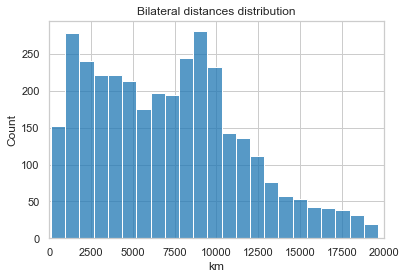

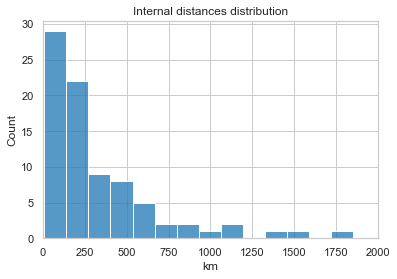

In [35]:
### CEPII DISTANCES: STATS

### Countries stats:
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
ser_dist = pd.read_hdf(path_or_buf = str_path_cepii_dataset, key = str_distance_dataset)['distw']
ser_dist_outer = ser_dist[ser_dist.index.get_level_values(0) != ser_dist.index.get_level_values(1)]
ser_dist_inner = ser_dist[ser_dist.index.get_level_values(0) == ser_dist.index.get_level_values(1)]
print('Example :\n', ser_dist.loc[['AU', 'US'], ['AU', 'US']])
set_from = set(ser_dist_outer.index.get_level_values(0))
set_to = set(ser_dist_outer.index.get_level_values(1))
print('Unique \"From\" countries number :\n', len(set_from))
print('ISON countries not in \"From\" :\n', set_ison_countries - set_from)
print('Unique \"To\" countries number :\n', len(set_to))
print('ISON countries not in \"To\" :\n', set_ison_countries - set_to)
print('NaN values number :\n', len(ser_dist[ser_dist.isna()]))
### Pairs stats:
print('Sample bilateral pairs number vs Theoretical bilateral pairs number :\n', len(ser_dist_outer) // 2, 'vs', len(set_from) * (len(set_from) - 1) // 2)
print('Asymmetric bilateral distances :\n', 
      [(iter_from, iter_to) for iter_from in set_from for iter_to in set_to if (ser_dist[iter_from, iter_to] != ser_dist[iter_to, iter_from])])
### Distances stats:
print('Maximal bilateral distance :\n', ser_dist_outer[ser_dist_outer == max(ser_dist_outer)])
print('Minimal bilateral distance :\n', ser_dist_outer[ser_dist_outer == min(ser_dist_outer)])
print('Maximal inner distance :\n', ser_dist_inner[ser_dist_inner == max(ser_dist_inner)])
print('Minimal inner distance :\n', ser_dist_inner[ser_dist_inner == min(ser_dist_inner)])
sns.set_style('whitegrid')
sns.set_context('notebook')
ax_outer = sns.histplot(ser_dist_outer.loc[sorted(list(itertools.combinations(set_from, 2)))].values, kde = False)
ax_outer.set_title('Bilateral distances distribution')
ax_outer.set(xlim = (0, 20000), xlabel = 'km')
plt.show()
ax_inner = sns.histplot(ser_dist_inner.values, kde = False)
ax_inner.set_title('Internal distances distribution')
ax_inner.set(xlim = (0, 2000), xlabel = 'km')
plt.show()

In [8]:
### UN COMTRADE

In [9]:
### UN COMTRADE: GENERAL DATA PREPARATION

### Constants:
int_seconds_to_sleep = 40
int_unc_limit = 5
### USA before 1981 code:
str_usa_1981 = '841'
### UN Comtrade country names to rename:
dict_map_to_replace = {'BOLIVIA (PLURINATIONAL STATE OF)': 'BOLIVIA',
                       'BOSNIA HERZEGOVINA': 'BOSNIA AND HERZEGOVINA',
                       'BR. INDIAN OCEAN TERR.': 'BRITISH INDIAN OCEAN TERRITORY',
                       'BR. VIRGIN ISDS': 'BRITISH VIRGIN ISLANDS',
                       'BRUNEI DARUSSALAM': 'BRUNEI',
                       'CABO VERDE': 'CAPE VERDE',
                       'CAYMAN ISDS': 'CAYMAN ISLANDS',
                       'CENTRAL AFRICAN REP.': 'CENTRAL AFRICAN REPUBLIC',
                       'CHRISTMAS ISDS': 'CHRISTMAS ISLAND',
                       'COCOS ISDS': 'COCOS ISLANDS',
                       'COOK ISDS': 'COOK ISLANDS',                    
                       'CURAÇAO': 'CURACAO',                          
                       'CZECHIA': 'CZECH REPUBLIC',                    
                       'DEM. REP. OF THE CONGO': 'DEMOCRATIC REPUBLIC OF THE CONGO',                          
                       'DOMINICAN REP.': 'DOMINICAN REPUBLIC',                    
                       'TIMOR-LESTE': 'EAST TIMOR',                          
                       'FALKLAND ISDS (MALVINAS)': 'FALKLAND ISLANDS',                    
                       'FAEROE ISDS': 'FAROE ISLANDS',                                           
                       'CHINA, HONG KONG SAR': 'HONG KONG',                          
                       'CÔTE D\'IVOIRE': 'IVORY COAST',                                           
                       'LAO PEOPLE\'S DEM. REP.': 'LAOS',                                         
                       'CHINA, MACAO SAR': 'MACAU',                          
                       'TFYR OF MACEDONIA': 'MACEDONIA',                    
                       'MARSHALL ISDS': 'MARSHALL ISLANDS',                          
                       'FS MICRONESIA': 'MICRONESIA',                    
                       'REP. OF MOLDOVA': 'MOLDOVA',                          
                       'NETH. ANTILLES': 'NETHERLANDS ANTILLES',                          
                       'DEM. PEOPLE\'S REP. OF KOREA': 'NORTH KOREA',                          
                       'N. MARIANA ISDS': 'NORTHERN MARIANA ISLANDS',                    
                       'STATE OF PALESTINE': 'PALESTINE',                          
                       'CONGO': 'REPUBLIC OF THE CONGO',                          
                       'RÉUNION': 'REUNION',                    
                       'RUSSIAN FEDERATION': 'RUSSIA',                          
                       'SOLOMON ISDS': 'SOLOMON ISLANDS',                    
                       'REP. OF KOREA': 'SOUTH KOREA',                                       
                       'UNITED REP. OF TANZANIA': 'TANZANIA',     
                       'OTHER ASIA, NES': 'TAIWAN',
                       'TURKS AND CAICOS ISDS': 'TURKS AND CAICOS ISLANDS',                    
                       'US VIRGIN ISDS': 'U.S. VIRGIN ISLANDS',                          
                       'USA': 'UNITED STATES',                          
                       'HOLY SEE (VATICAN CITY STATE)': 'VATICAN',                    
                       'VIET NAM': 'VIETNAM',                          
                       'WALLIS AND FUTUNA ISDS': 'WALLIS AND FUTUNA'
                      }

In [ ]:
### UN COMTRADE: COUNTRIES DATA EXTRACTION AND MODIFICATION

def get_un_comtrade_country_id(df_country_codes):
    ### Getting UN Comtrade country info from post request:
    str_UNC_countries_set = 'http://comtrade.un.org/data/cache/partnerAreas.json'
    obj_UNC_countries_set = requests.post(str_UNC_countries_set)
    ### Object to dataframe transformation:
    list_UNC_countries = obj_UNC_countries_set.json()['results']
    df_UNC_countries = pd.DataFrame(list_UNC_countries)
    df_UNC_countries.columns = ['UNC ID', 'COUNTRY']
    df_UNC_countries['COUNTRY'] = df_UNC_countries['COUNTRY'].str.upper()
    df_UNC_countries.replace(dict_map_to_replace, inplace = True)
    df_UNC_countries.set_index('COUNTRY', append = False, drop = True, inplace = True)
    df_UNC_country_id = df_UNC_countries.join(df_country_codes, on = 'COUNTRY', how = 'left').dropna(how = 'any').reset_index(drop = True)
    df_UNC_country_id.drop('ISO LONG', axis = 1, inplace = True)
    df_UNC_country_id.columns = ['Comtrade_ID', 'Country']
    ser_UNC_country_id = df_UNC_country_id.set_index('Country').squeeze().sort_index()
    ### Results output:
    return ser_UNC_country_id

### Getting UN Comtrade country IDs:
ser_UNC_country_id = get_un_comtrade_country_id(df_country_codes)
### Filtering ISON countries only & adding USA BEFORE 1981 CODE:
ser_UNC_country_id = ser_UNC_country_id.reindex(ser_ison_membership.index.get_level_values(1).unique()).append(pd.Series('841', ['US'])).sort_index()

In [ ]:
### UN COMTRADE: DATA REQUEST EXECUTION

def get_un_comtrade_data(str_rep_country_id, str_par_country_id, int_max_rec = 99999, str_type = 'C', str_freq = 'A', str_classification_system = 'S1', 
                         str_period = 'all', str_trade_flow = 'All', str_classification_code = 'TOTAL'):
    ### Trade flows codification:
    dict_trade_flow = {'All': 'all', 'Import': '1', 'Export': '2', 're-Export': '3', 're-Import': '4'}
    ### URL prefix:
    str_url_base = 'http://comtrade.un.org/api/get?'
    ### Request URL preparation:
    str_url_request = str_url_base
    list_parameters = []
    list_parameters.append('max=' + str(int_max_rec)) # Usage limit
    list_parameters.append('type=' + str_type) # C = Commodities (merchandise trade data) / S = Services (trade in services data)
    list_parameters.append('freq=' + str_freq) # A = Annual, M = Mpnthly
    list_parameters.append('px=' + str_classification_system) # Trade data classification scheme. See list of valid classifications
    list_parameters.append('ps=' + str_period) # Time period
    list_parameters.append('r=' + str_rep_country_id) # Reporter country
    list_parameters.append('p=' + str_par_country_id) # Partner country
    list_parameters.append('rg=' + dict_trade_flow[str_trade_flow]) # Trade direction
    list_parameters.append('cc=' + str_classification_code) # Commodity code
    list_parameters.append('fmt=json')        
    str_url_request += '&'.join(list_parameters)
    ### Getting UN Comtrade data from post request:    
    obj_unc_dataset = requests.post(str_url_request)
    ### Object to dataframe transformation:    
    if ('dataset' in obj_unc_dataset.json().keys()):
        list_unc_dataset = obj_unc_dataset.json()['dataset']
        if (len(list_unc_dataset) > 1):
            df_unc_dataset = pd.DataFrame(list_unc_dataset)[['period', 'rtCode', 'ptCode', 'TradeValue']]
            df_unc_dataset.columns = ['Period', 'Reporter_ID', 'Partner_ID', 'Value']  
            if (str_freq == 'M'):
                df_unc_dataset['Date'] = pd.to_datetime(df_unc_dataset['Period'], format = '%Y%m') + pd.offsets.BMonthEnd()    
            elif (str_freq == 'A'):
                df_unc_dataset['Date'] = pd.to_datetime(df_unc_dataset['Period'], format = '%Y') + pd.offsets.BYearEnd()    
            df_unc_dataset = df_unc_dataset[['Date', 'Reporter_ID', 'Partner_ID', 'Value']]
        else:
            df_unc_dataset = pd.DataFrame(columns = ['Date', 'Reporter_ID', 'Partner_ID', 'Value'])
    else:
        df_unc_dataset = pd.DataFrame(columns = ['Date', 'Reporter_ID', 'Partner_ID', 'Value'])
    ### Results output:
    return df_unc_dataset

In [ ]:
### UN COMTRADE: MAIN EXPORT DATA EXTRACTION SCRIPT

### Concatenation aggregator initializing:
list_exp_dataset = []
### Empty request collection:
list_empty_exp_requests = []
### Reporter country looping (5 country groups):
for iter_reporter_group in range((len(ser_UNC_country_id.index) - 1) // int_unc_limit + 1):
    ### Partner country looping (5 country groups):
    for iter_partner_group in range((len(ser_UNC_country_id.index) - 1) // int_unc_limit + 1):
        print(iter_reporter_group * int_unc_limit, '-', (iter_reporter_group + 1) * int_unc_limit - 1, '/', 
              iter_partner_group * int_unc_limit, '-', (iter_partner_group + 1) * int_unc_limit - 1)     
        ### Country groups preparing:
        str_reporter_group = ','.join(ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list())
        str_partner_group = ','.join(ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list())    
        ### Request performing:
        df_iter_dataset = get_un_comtrade_data(str_reporter_group, str_partner_group, str_trade_flow = 'Export')
        if (len(df_iter_dataset) > 1):
            list_exp_dataset += [df_iter_dataset]
            print(len(df_iter_dataset), 'rows of data loaded successfully')
        elif (len(df_iter_dataset) == 1):
            list_empty_exp_requests.append((iter_reporter_group, iter_partner_group))
            print('Request error (zero-valued single line)')
        else:
            list_empty_exp_requests.append((iter_reporter_group, iter_partner_group))
            print('Request error (empty dataset)')
        ### Pause for API limitations:
#        break        
        time.sleep(int_seconds_to_sleep)            
#    break

In [35]:
### UN COMTRADE: EXPORT DATA TEST:

print(len(list_exp_dataset), ' + ', len(list_empty_exp_requests)) ### 323  +  0

323  +  0


In [ ]:
### UN COMTRADE: ADDING LOST EXPORT DATA

list_double_error = []
### Request error pairs looping:
for (iter_reporter_group, iter_partner_group) in list_empty_exp_requests:
    print(iter_reporter_group * int_unc_limit, '-', (iter_reporter_group + 1) * int_unc_limit - 1, '/', 
          iter_partner_group * int_unc_limit, '-', (iter_partner_group + 1) * int_unc_limit - 1)
    ### Country groups preparing:
    str_reporter_group = ','.join(ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list())
    str_partner_group = ','.join(ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list())    
    ### Request performing:
    df_iter_dataset = get_un_comtrade_data(str_reporter_group, str_partner_group, str_trade_flow = 'Export')
    if (len(df_iter_dataset) > 0):
        list_exp_dataset += [df_iter_dataset]
        print(len(df_iter_dataset), 'rows of data loaded successfully')
    else:
        list_double_error.append((iter_reporter_group, iter_partner_group))        
        print('Double request error')
    ### Pause for API limitations:        
    time.sleep(int_seconds_to_sleep)     
### Saving repeated error pairs:
list_empty_exp_requests = list_double_error    

In [43]:
### UN COMTRADE: EXPORT DATA SAVING

### Results concatenating:
df_loop_dataset = pd.concat(list_exp_dataset, axis = 0, sort = False, ignore_index = True)[['Date', 'Reporter_ID', 'Partner_ID', 'Value']]
df_loop_dataset = df_loop_dataset.astype({'Reporter_ID': 'int16', 'Partner_ID': 'int16', 'Value': 'int64'})
### UN Comtrade country codes replacing to ISON country codes:
df_loop_dataset.loc[All, ['Reporter_ID', 'Partner_ID']] = df_loop_dataset.loc[All, ['Reporter_ID', 'Partner_ID']]\
                                                                         .replace(list(map(int, ser_UNC_country_id.values)), ser_UNC_country_id.index.to_list())
df_loop_dataset = df_loop_dataset[df_loop_dataset['Reporter_ID'] != df_loop_dataset['Partner_ID']]
### Series indexing:
ser_unc_dataset = df_loop_dataset.set_index(['Date', 'Reporter_ID', 'Partner_ID'], drop = True).squeeze().sort_index()
### Data saving:
ser_unc_dataset.to_hdf(path_or_buf = str_path_unc_dataset, key = str_unc_exp_total_dataset, mode = 'w')

In [19]:
### UN COMTRADE: EXPORT DATA TEST:

ser_exp_dataset = pd.read_hdf(path_or_buf = str_path_unc_dataset, key = str_unc_exp_total_dataset)
set_exp_pairs = set(ser_exp_dataset.reset_index('Date', drop = True).index.drop_duplicates())
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
set_ison_pairs = set(itertools.permutations(set_ison_countries, 2))
print(set_ison_pairs - set_exp_pairs)
ser_exp_dataset.loc[:, ['IL', 'US'], ['IL', 'US']]

{('JO', 'BW'), ('QA', 'IL'), ('LB', 'IL'), ('KZ', 'BW'), ('PA', 'KZ'), ('CR', 'NA'), ('KW', 'IL'), ('MA', 'IL'), ('PK', 'IL'), ('PA', 'BW')}


Date        Reporter_ID  Partner_ID
1962-12-31  IL           US               42312816
            US           IL              161118576
1963-12-31  IL           US               46352212
            US           IL              154373280
1964-12-31  IL           US               54651532
                                          ...     
2018-12-31  US           IL            13703837823
2019-12-31  IL           US            15958429000
            US           IL            14374816188
2020-12-31  IL           US            13135988000
            US           IL            10186753091
Name: Value, Length: 118, dtype: int64

In [ ]:
### UN COMTRADE: MAIN IMPORT DATA EXTRACTION SCRIPT

### Concatenation aggregator initializing:
list_imp_dataset = []
### Empty request collection:
list_empty_imp_requests = []
### Reporter country looping (5 country groups):
for iter_reporter_group in range((len(ser_UNC_country_id.index) - 1) // int_unc_limit + 1):
    ### Partner country looping (5 country groups):    
    for iter_partner_group in range((len(ser_UNC_country_id.index) - 1) // int_unc_limit + 1):
        print(iter_reporter_group * int_unc_limit, '-', (iter_reporter_group + 1) * int_unc_limit - 1, '/', 
              iter_partner_group * int_unc_limit, '-', (iter_partner_group + 1) * int_unc_limit - 1)
        ### Country groups preparing:
        str_reporter_group = ','.join(ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list())
        str_partner_group = ','.join(ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list())    
        ### Request performing:        
        df_iter_dataset = get_un_comtrade_data(str_reporter_group, str_partner_group, str_trade_flow = 'Import')
        if (len(df_iter_dataset) > 1):
            list_imp_dataset += [df_iter_dataset]
            print(len(df_iter_dataset), 'rows of data loaded successfully')
        elif (len(df_iter_dataset) == 1):
            list_empty_imp_requests.append((iter_reporter_group, iter_partner_group))
            print('Request error (zero-valued single line)')
        else:
            list_empty_imp_requests.append((iter_reporter_group, iter_partner_group))
            print('Request error (empty dataset)')         
        ### Pause for API limitations:        
        time.sleep(int_seconds_to_sleep)            
#    break

In [18]:
### UN COMTRADE: IMPORT DATA TEST:

print(len(list_imp_dataset), ' + ', len(list_empty_imp_requests)) ### 323  +  1

323  +  1


In [ ]:
### UN COMTRADE: ADDING LOST IMPORT DATA

list_double_error = []
### Request error pairs looping:
for (iter_reporter_group, iter_partner_group) in list_empty_imp_requests:
    print(iter_reporter_group * int_unc_limit, '-', (iter_reporter_group + 1) * int_unc_limit - 1, '/', 
          iter_partner_group * int_unc_limit, '-', (iter_partner_group + 1) * int_unc_limit - 1)
    ### Country groups preparing:
    str_reporter_group = ','.join(ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list())
    str_partner_group = ','.join(ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list())    
    ### Request performing:
    df_iter_dataset = get_un_comtrade_data(str_reporter_group, str_partner_group, str_trade_flow = 'Import')
    if (len(df_iter_dataset) > 0):
        list_imp_dataset += [df_iter_dataset]
        print(len(df_iter_dataset), 'rows of data loaded successfully')
    else:
        list_double_error.append((iter_reporter_group, iter_partner_group))
        print('Double request error')
    ### Pause for API limitations:        
    time.sleep(int_seconds_to_sleep)      
### Saving repeated error pairs:
list_empty_imp_requests = list_double_error        

In [20]:
### UN COMTRADE: IMPORT DATA SAVING

### Results concatenating:
df_loop_dataset = pd.concat(list_imp_dataset, axis = 0, sort = False, ignore_index = True)[['Date', 'Reporter_ID', 'Partner_ID', 'Value']]
df_loop_dataset = df_loop_dataset.astype({'Reporter_ID': 'int16', 'Partner_ID': 'int16', 'Value': 'int64'})
### UN Comtrade country codes replacing to ISON country codes:
df_loop_dataset.loc[All, ['Reporter_ID', 'Partner_ID']] = df_loop_dataset.loc[All, ['Reporter_ID', 'Partner_ID']]\
                                                                         .replace(list(map(int, ser_UNC_country_id.values)), ser_UNC_country_id.index.to_list())
df_loop_dataset = df_loop_dataset[df_loop_dataset['Reporter_ID'] != df_loop_dataset['Partner_ID']]
### Series indexing:
ser_unc_dataset = df_loop_dataset.set_index(['Date', 'Reporter_ID', 'Partner_ID'], drop = True).squeeze()
### Data saving:
ser_unc_dataset.to_hdf(path_or_buf = str_path_unc_dataset, key = str_unc_imp_total_dataset, mode = 'r+')

In [23]:
### UN COMTRADE: IMPORT DATA TEST

ser_imp_dataset = pd.read_hdf(path_or_buf = str_path_unc_dataset, key = str_unc_imp_total_dataset)
set_imp_pairs = set(ser_imp_dataset.reset_index('Date', drop = True).index.drop_duplicates())
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
set_ison_pairs = set(itertools.permutations(set_ison_countries, 2))
print(set_ison_pairs - set_imp_pairs)
ser_imp_dataset.loc[:, ['IL', 'US'], ['IL', 'US']].sort_index()

{('JO', 'BW'), ('PA', 'GH'), ('KW', 'IL'), ('MA', 'IL'), ('LB', 'IL'), ('PA', 'BW'), ('PK', 'IL'), ('PA', 'NA')}


Date        Reporter_ID  Partner_ID
1962-12-31  IL           US              208446032
            US           IL               41038188
1963-12-31  IL           US              185353984
            US           IL               47066908
1964-12-31  IL           US              202094384
                                          ...     
2018-12-31  US           IL            22178525308
2019-12-31  IL           US            12823755000
            US           IL            19892209912
2020-12-31  IL           US             8045806000
            US           IL            15597559932
Name: Value, Length: 118, dtype: int64

In [9]:
### UN COMTRADE: IMPORT DATA EXAMPLE

ser_unc_total_export = pd.read_hdf(path_or_buf = str_path_unc_dataset, key = str_unc_exp_total_dataset)
ser_unc_total_import = pd.read_hdf(path_or_buf = str_path_unc_dataset, key = str_unc_imp_total_dataset)
ser_unc_full = pd.concat([ser_unc_total_export, ser_unc_total_import], keys = ['Export', 'Import'], names = ['Flow'])
ser_unc_full = ser_unc_full[ser_unc_full.index.get_level_values('Reporter_ID') != ser_unc_full.index.get_level_values('Partner_ID')]
list_to_plot = ['IL', 'US']
str_date_to_compare = '2020-12-31'
print(ser_unc_full.loc[All, ['1962-12-31', '2020-12-31'], list_to_plot, list_to_plot].unstack(['Flow']))

Flow                                    Export       Import
Date       Reporter_ID Partner_ID                          
1962-12-31 IL          US             42312816    208446032
           US          IL            161118576     41038188
2020-12-31 IL          US          13135988000   8045806000
           US          IL          10186753091  15597559932


<Figure size 1080x360 with 0 Axes>

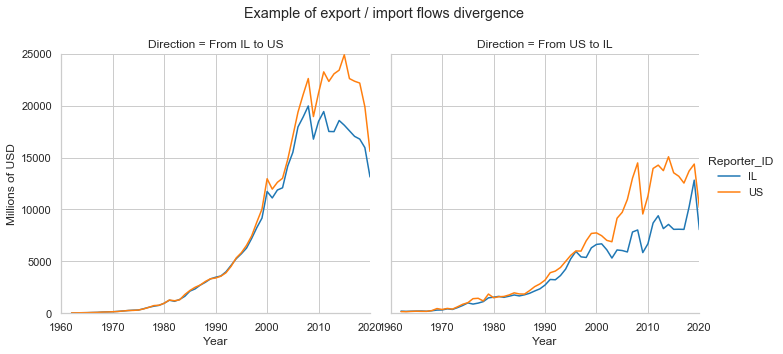

In [10]:
### UN COMTRADE: IMPORT DATA EXAMPLE

list_to_plot = ['IL', 'US']
df_to_plot = ser_unc_full.loc[All, All, list_to_plot, list_to_plot].reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Direction'] = ((df_to_plot['Flow'] == 'Export') & (df_to_plot['Reporter_ID'] == 'IL')) | \
                          ((df_to_plot['Flow'] == 'Import') & (df_to_plot['Reporter_ID'] == 'US'))
df_to_plot.loc[~df_to_plot['Direction'], 'Direction'] = 'From US to IL'
df_to_plot.loc[df_to_plot['Direction'] == True, 'Direction'] = 'From IL to US'
df_to_plot['Value'] = df_to_plot['Value'] / 1000000
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
fig_example = sns.relplot(data = df_to_plot, x = 'Year', y = 'Value', col = 'Direction', hue = 'Reporter_ID', kind = 'line')
fig_example.set(ylim = (0, 25000), xlim = (1960, date_end.year), ylabel = 'Millions of USD')
fig_example.fig.subplots_adjust(top = 0.85)
fig_example.fig.suptitle('Example of export / import flows divergence')
plt.show()

In [ ]:
### UN COMTRADE: STATS

### Bilateral permutations of ISON countries
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
set_ison_pairs = set(itertools.permutations(set_ison_countries, 2))
### Comtrade data loading:
ser_unc_total_export = pd.read_hdf(path_or_buf = str_path_unc_dataset, key = str_unc_exp_total_dataset)
ser_unc_total_import = pd.read_hdf(path_or_buf = str_path_unc_dataset, key = str_unc_imp_total_dataset)
ser_unc_full = pd.concat([ser_unc_total_export, ser_unc_total_import], keys = ['Export', 'Import'], names = ['Flow'])
ser_unc_full = ser_unc_full[ser_unc_full.index.get_level_values('Reporter_ID') != ser_unc_full.index.get_level_values('Partner_ID')]
ser_unc_data = ser_unc_full.loc[:, pd.date_range(date_start, date_end, freq = 'BY'), : , :]
### Countries number:
print('Export Reporters:', len((ser_unc_data.loc['Export'].index.get_level_values('Reporter_ID').unique())))
print('Export Partners:', len((ser_unc_data.loc['Export'].index.get_level_values('Partner_ID').unique())))
print('Import Reporters:', len((ser_unc_data.loc['Import'].index.get_level_values('Reporter_ID').unique())))
print('Import Partners:', len((ser_unc_data.loc['Import'].index.get_level_values('Partner_ID').unique())))
### Pairs comparision:
set_exp_pairs = set(iter_pair for iter_pair in ser_unc_data.loc['Export'].reset_index('Date', drop = True).index.drop_duplicates() if iter_pair[0] != iter_pair[1])
set_imp_pairs = set(iter_pair for iter_pair in ser_unc_data.loc['Import'].reset_index('Date', drop = True).index.drop_duplicates() if iter_pair[0] != iter_pair[1])
print('Export pairs number:', len(set_exp_pairs))
print('Absent export pairs:', sorted(list(set_ison_pairs - set_exp_pairs)))
print('Import pairs number:', len(set_imp_pairs))
print('Absent import pairs:', sorted(list(set_ison_pairs - set_imp_pairs)))
### Data availability:
sns.set_style('whitegrid')
plt.rcParams.update({"xtick.bottom" : True})
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
df_to_plot = (ser_unc_data.groupby(['Flow', 'Date']).count() / (int_ison_number * (int_ison_number - 1)) * 100).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot.rename(columns = {'Value': '%'}, inplace = True)
ax_flows = sns.lineplot(data = df_to_plot, x = 'Year', y = '%', hue = 'Flow')
ax_flows.set(ylim = (50, 100), xlim = (date_start.year, date_end.year))
ax_flows.xaxis.set_major_locator(mticker.IndexLocator(5, 1))
ax_flows.xaxis.set_minor_locator(mticker.IndexLocator(1, 0))
ax_flows.set_title('Proportion of bilateral pairs available', fontsize = 15)
plt.show()
print('Aggregates of bilateral pairs available observations proportion, %:\n', 
      (ser_unc_data.groupby(['Flow', 'Reporter_ID', 'Partner_ID']).count() / (date_end.year - date_start.year + 1) * 100).groupby('Flow').agg([min, np.median, max])\
      .round())
df_to_plot = (ser_unc_data.groupby(['Flow', 'Reporter_ID', 'Partner_ID']).count() / (date_end.year - date_start.year + 1) * 100).droplevel(['Reporter_ID', 'Partner_ID'])\
                                                                                                                                .reset_index()
list_col_order = ['Export', 'Import']
fig_pairs_available = sns.displot(data = df_to_plot, col_order = list_col_order, col = 'Flow', hue = 'Flow', x = 'Value', 
                                  kde = False, bins = 20, stat = 'percent', common_norm = False)
fig_pairs_available.fig.subplots_adjust(top = 0.85)
fig_pairs_available.fig.suptitle('Distribution of bilateral flows observations availability')
fig_pairs_available.set(xlim = (0, 100), xlabel = 'Proportion of observations available for bilateral flow', ylabel = '')
for ax_iter, flow_iter in zip(fig_pairs_available.axes.flat, list_col_order):
    ax_iter.axvline(x = df_to_plot.loc[df_to_plot['Flow'] == flow_iter, 'Value'].median(), color = 'r', linestyle = '--', label = 'Median')
    ax_iter.legend()
fig_pairs_available._legend.remove()
plt.show()
### Empty observations:
ser_unc_total_import_inv = ser_unc_total_import + 0.0
ser_unc_total_import_inv = ser_unc_total_import_inv.reorder_levels([0, 2, 1]).sort_index()
ser_unc_total_import_inv.index.set_names([ser_unc_total_import_inv.index.names[0], ser_unc_total_import_inv.index.names[2], ser_unc_total_import_inv.index.names[1]],
                                         inplace = True)
ser_unc_total_export.name = 'Export_View'
ser_unc_total_import_inv.name = 'Import_View'
df_unc_flows = pd.concat([ser_unc_total_export, ser_unc_total_import_inv], axis  = 1)
df_unc_flows.index.set_names(['Out_ID', 'In_ID'], level = ['Reporter_ID', 'Partner_ID'], inplace = True)
df_unc_flows = df_unc_flows[df_unc_flows.index.get_level_values('Out_ID') != df_unc_flows.index.get_level_values('In_ID')]
df_unc_flows = df_unc_flows.loc[(pd.date_range(date_start, date_end, freq = 'BY'), All , All), :]
df_unc_flows.loc[(str_date_to_compare, 'CN', 'US'), :]
print('Observation dates number:', len(df_unc_flows.index))
print('Proportion of observations with both values available:', round(len(df_unc_flows.dropna().index) / len(df_unc_flows.index), 2))
print('Proportion of observations with both values absent:', round(df_unc_flows.isna().all(axis = 1).sum() / len(df_unc_flows.index), 2))
print('Proportion of observations with no export report:', round(df_unc_flows['Export_View'].isna().sum() / len(df_unc_flows.index), 2))
print('Proportion of observations with no import report:', round(df_unc_flows['Import_View'].isna().sum() / len(df_unc_flows.index), 2))
### Export to Import correspondence:
df_unc_diver = df_unc_flows.copy()
flo_div_coeff = 3 / 2
df_unc_diver['Flows_Ratio'] = df_unc_diver['Export_View'] / df_unc_diver['Import_View']
df_unc_diver['Flows_Divergency'] = 'Acceptable deviation'
df_unc_diver.loc[(df_unc_diver['Flows_Ratio'] > flo_div_coeff) | (df_unc_diver['Flows_Ratio'] < (1 / flo_div_coeff)), 'Flows_Divergency'] = 'Critical deviation'
df_unc_diver[['Export_View', 'Import_View']] = df_unc_diver[['Export_View', 'Import_View']] / 1000000000
plt.figure(figsize = (7, 7))
ax_divergence = sns.scatterplot(data = df_unc_diver, x = 'Export_View', y  = 'Import_View', hue = 'Flows_Divergency', 
                                hue_order = ['Acceptable deviation', 'Critical deviation'])
ax_divergence.set(xlim = (0, 500), ylim = (0, 500), xlabel = 'Export view, billions of USD', ylabel = 'Import view, billions of USD')
plt.show()
print('Proportion of observations with bigger Export view: ', round(len(df_unc_flows[df_unc_flows['Export_View'] > df_unc_flows['Import_View']]) / len(df_unc_flows), 2))
print('Proportion of observations with bigger Import view: ', round(len(df_unc_flows[df_unc_flows['Export_View'] < df_unc_flows['Import_View']]) / len(df_unc_flows), 2))
### Common trade flow:
ser_unc_trade = df_unc_flows.max(axis = 1)
ser_unc_trade.name = 'Trade_Flow'
df_to_plot = ser_unc_trade.groupby(['Date']).sum().reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Trade_Flow'] = df_to_plot['Trade_Flow'] / 1000000000000
ax_world_trade = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Trade_Flow')
ax_world_trade.set(xlim = (date_start.year, date_end.year), ylabel = 'Trillions of USD', title = 'ISON countries bilateral trade volume')
plt.show()
### 2020 stats:
ser_2020_data = ser_unc_trade.loc[str_date_to_compare, All, All].reset_index('Date', drop = True)
print('2020 minimums:\n', ser_2020_data[ser_2020_data == ser_2020_data.min()])
print('2020 maximums:\n', ser_2020_data[ser_2020_data == ser_2020_data.max()])
print('2020 medians:\n', ser_2020_data.median())
ser_2020_data = ser_unc_trade.loc[str_date_to_compare, All, All].reset_index('Date', drop = True)
list_leaders = sorted(['US', 'CN', 'JP', 'DE', 'GB', 'IN', 'FR', 'IT', 'CA', 'KR'])

ser_2020_leaders = (ser_2020_data.loc[list_leaders, list_leaders] / 1000000000).sort_index().astype(int)
df_2020_leaders = ser_2020_leaders.unstack('In_ID').sort_index(axis = 1)
plt.figure(figsize = (7, 7))
ax_heatmap = sns.heatmap(df_2020_leaders, cmap= 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = True, annot = True, fmt = '.0f', 
                         center = 150)
ax_heatmap.set(xlabel = 'Importer', ylabel = 'Exporter')
ax_heatmap.set_title('2020 trade flows, billions of USD', fontsize = 15)
plt.show()

In [58]:
### TEST: OUTLIERS RECOGNITION: CORRELATION CHECK

### Top vector size:
int_largest = 10
### Defining Export/Import view correlation calculator for top-10 export receivers:
def corr_checker(df_group, int_n):
    df_top_corr = df_group.nlargest(int_n, 'Export_View').corr(min_periods = 3).iloc[0, 1]
    return df_top_corr
### Date/Country correlations:
ser_unx_check = df_unc_flows.dropna().groupby(['Date', 'Out_ID'], group_keys = True).apply(corr_checker, int_largest)

In [89]:
### TEST: OUTLIERS RECOGNITION: CORRELATION CHECK

flo_limit = 0.95

#df_unc_flows.loc['2020-12-31', 'UG', All].nlargest(int_largest, 'Export_View')
print('Critical deviation vectors:', round(len(ser_unx_check[ser_unx_check < flo_limit]) / len(ser_unx_check), 2))

Critical deviation vectors: 0.36


In [90]:
### TEST: OUTLIERS RECOGNITION: DEVIATION CHECK

### Deviation limitation to control:
flo_dev_limit = 3 / 2

### Top size vectors filtering:
df_unx_top = df_unc_flows.dropna().groupby(['Date', 'Out_ID'], group_keys = False).apply(lambda df: df.nlargest(int_largest, 'Export_View'))
### Controls adding:
df_unx_top['Flows_Ratio'] = df_unx_top['Export_View'] / df_unx_top['Import_View']
df_unx_top['Alarm_Flag'] = False
df_unx_top.loc[(df_unx_top['Flows_Ratio'] > flo_dev_limit) | (df_unx_top['Flows_Ratio'] < (1 / flo_dev_limit)), 'Alarm_Flag'] = True
print('Critical deviation pairs:', round(df_unx_top['Alarm_Flag'].sum() / len(df_unx_top['Alarm_Flag']), 2))

Critical deviation pairs: 0.24


In [86]:
### TEST: OUTLIERS RECOGNITION: DIRECT CHECK



0.23532001761197616

In [36]:
### IMF CPIS: BILATERAL EQUITY & DEBT INVESTMENT POSITIONS

In [37]:
### IMF CPIS: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
dict_request_headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
str_imf_base_url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
str_imf_dataflow_add = 'DataFlow'
str_imf_datastructure_add = 'DataStructure/'
str_imf_codelist_add = 'CodeList/'
str_imf_dataset_add = 'CompactData/'
int_seconds_to_sleep = 5
int_imf_country_limit = 30

In [38]:
### IMF CPIS: REQUESTS SESSION INITIALIZING

request_session = requests.Session()
### For avoiding data request errors from IMF Data Service:
request_session.headers.update({'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'})

In [39]:
### IMF CPIS: DATAFLOW SEARCHING

obj_imf_dataflow_list = request_session.get(str_imf_base_url + str_imf_dataflow_add).json()
df_imf_dataflow = pd.DataFrame(obj_imf_dataflow_list['Structure']['Dataflows']['Dataflow'])
df_imf_dataflow = df_imf_dataflow.assign(Description = df_imf_dataflow['Name'].apply(pd.Series)['#text'].values)[['@id', 'Description']]
ser_imf_dataflow = df_imf_dataflow.set_index('@id', drop = True).squeeze()
### Searching DataFlow code for further requests:
str_imf_cpis_id = ser_imf_dataflow[ser_imf_dataflow.str.contains('CPIS')].index[0].replace('DS-', '')
print(str_imf_cpis_id)

CPIS


In [40]:
### IMF CPIS: DATASTRUCTURE SEARCHING

obj_imf_cpis_structure = request_session.get(str_imf_base_url + str_imf_datastructure_add + str_imf_cpis_id).json()
df_imf_cpis_params = pd.DataFrame(obj_imf_cpis_structure['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension'])\
                                [['@conceptRef', '@codelist', '@isFrequencyDimension']]
### Receiving DataFlow parameters and code lists for each of them:
print(df_imf_cpis_params)

          @conceptRef          @codelist @isFrequencyDimension
0                FREQ            CL_FREQ                  true
1            REF_AREA       CL_AREA_CPIS                   NaN
2           INDICATOR  CL_INDICATOR_CPIS                   NaN
3          REF_SECTOR     CL_SECTOR_CPIS                   NaN
4  COUNTERPART_SECTOR     CL_SECTOR_CPIS                   NaN
5    COUNTERPART_AREA       CL_AREA_CPIS                   NaN


In [ ]:
### IMF CPIS: CODES DESCRIPTION SEARCHING

for int_counter, str_param_code in enumerate(df_imf_cpis_params['@codelist']):
    if (int_counter >= 0):
        time.sleep(int_seconds_to_sleep)    
        obj_imf_cpis_param = request_session.get(str_imf_base_url + str_imf_codelist_add + str_param_code).json()
        df_imf_cpis_param =  pd.DataFrame(obj_imf_cpis_param['Structure']['CodeLists']['CodeList']['Code'])
        ### Receiving values for each code list:
        df_imf_cpis_param = df_imf_cpis_param.assign(Text = df_imf_cpis_param['Description'].apply(pd.Series)['#text'].values)[['@value', 'Text']]
        print(int_counter, ':', df_imf_cpis_params.iloc[int_counter, All]['@conceptRef'], ':', str_param_code, ':\n', df_imf_cpis_param.head(20))
    
str_cpis_freq = 'A' # 'B' # 
str_cpis_asset_indicator = 'I_A_T_T_T_BP6_USD' 
str_cpis_liability_indicator = 'I_L_T_T_T_BP6_USD'
str_cpis_ref_sector = 'T'
str_cpis_cp_sector = 'T'
list_ison_countries = sorted(list(map(str, ser_ison_membership.index.get_level_values(1).unique())))
# 0: FREQ == 'B' # Semi-annual frequency - they don't have Quaterly or Monthly frequency data
# 1: REF_AREA == '??' # Country
# 2: INDICATOR  == 'I_A_T_T_T_BP6_USD' # Assets, Total Investment, BPM6, US Dollars & I_L_T_T_T_BP6_USD    Liabilities, Total Investment, BPM6, US Dollars
# 3: REF_SECTOR == 'T' # Total Holdings (all sectors)
# 4: COUNTERPART_SECTOR  == 'T' # Total Holdings (all sectors)
# 5: COUNTERPART_AREA == '??' # Country

In [42]:
### IMF CPIS ASSETS: REPORTED TOTAL PORTFOLIO INVESTMENT ASSET DATASET RETRIEVING

list_cpis_bilateral = [] # List of bilateral dataframes for future concatenation
str_cpis_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_cpis_id + '/' # Beggining of request URL
### Looping for reporter country groups:
for int_ison_reporter_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
    str_cpis_reporters = '+'.join(list_ison_countries[int_ison_reporter_part * int_imf_country_limit : (int_ison_reporter_part + 1) * int_imf_country_limit])
    ### Looping for partner country groups:
    for int_ison_partner_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
        str_cpis_partners = '+'.join(list_ison_countries[int_ison_partner_part * int_imf_country_limit : (int_ison_partner_part + 1) * int_imf_country_limit])    
        ### Generating complete request URL:
        str_cpis_full_url = str_cpis_const_url + \
                            '.'.join([str_cpis_freq, str_cpis_reporters, str_cpis_asset_indicator, str_cpis_ref_sector, str_cpis_ref_sector, str_cpis_partners])
        ### Receiving CPIS dataset from IMF API:
        print(int_ison_reporter_part * int_imf_country_limit, '-', (int_ison_reporter_part + 1) * int_imf_country_limit, ' / ',
              int_ison_partner_part * int_imf_country_limit, '-', (int_ison_partner_part + 1) * int_imf_country_limit)
        obj_cpis_set = request_session.get(str_cpis_full_url).json()
        ### Converting each bilateral dataset to dataframe and it's mungling:
        for dict_cpis_pair in obj_cpis_set['CompactData']['DataSet']['Series']:
            if isinstance(dict_cpis_pair['Obs'], list):
                df_cpis_bilateral = pd.DataFrame(dict_cpis_pair['Obs'])
            else:
                df_cpis_bilateral = pd.DataFrame([dict_cpis_pair['Obs']])
            df_cpis_bilateral = df_cpis_bilateral[['@TIME_PERIOD', '@OBS_VALUE']]
            df_cpis_bilateral.columns = ['Date', 'Value']
            df_cpis_bilateral = df_cpis_bilateral.assign(Reporter_ID = dict_cpis_pair['@REF_AREA'])
            df_cpis_bilateral = df_cpis_bilateral.assign(Partner_ID = dict_cpis_pair['@COUNTERPART_AREA'])
            list_cpis_bilateral.append(df_cpis_bilateral)   
### Bilateral dataset aggregating:
df_cpis = pd.concat(list_cpis_bilateral, axis = 0, ignore_index = True)
df_cpis = df_cpis[df_cpis['Reporter_ID'] != df_cpis['Partner_ID']]
df_cpis = df_cpis.astype({'Reporter_ID': 'str', 'Partner_ID': 'str', 'Value': 'float32'})
### Dataframe converting to stadartized format series:
df_cpis = pd.concat(list_cpis_bilateral, axis = 0, ignore_index = True)
df_cpis = df_cpis[df_cpis['Reporter_ID'] != df_cpis['Partner_ID']]
df_cpis = df_cpis.astype({'Reporter_ID': 'str', 'Partner_ID': 'str', 'Value': 'float32'})
df_cpis['Date'] = pd.to_datetime(df_cpis['Date']) + pd.offsets.BYearEnd()
ser_asset_cpis_data = df_cpis.set_index(['Date', 'Reporter_ID', 'Partner_ID']).squeeze()
### Series saving:
ser_asset_cpis_data.to_hdf(path_or_buf = str_path_imf_dataset, key = str_asset_imf_dataset, mode = 'w')

0 - 30  /  0 - 30
0 - 30  /  30 - 60
0 - 30  /  60 - 90
30 - 60  /  0 - 30
30 - 60  /  30 - 60
30 - 60  /  60 - 90
60 - 90  /  0 - 30
60 - 90  /  30 - 60
60 - 90  /  60 - 90


In [43]:
### IMF CPIS ASSETS: TEST

ser_test = pd.read_hdf(path_or_buf = str_path_imf_dataset, key = str_asset_imf_dataset)
ser_test.loc[All, ['IL', 'US'], ['IL', 'US']].sort_index()

Date        Reporter_ID  Partner_ID
1997-12-31  IL           US              1427.234009
            US           IL             12207.000000
2001-12-31  IL           US              5850.000000
            US           IL             21233.212891
2002-12-31  IL           US              7420.000000
            US           IL             20109.000000
2003-12-31  IL           US              8438.000000
            US           IL             28664.000000
2004-12-31  IL           US             10524.000000
            US           IL             34315.234375
2005-12-30  IL           US             14446.000000
            US           IL             44313.000000
2006-12-29  IL           US             21353.000000
            US           IL             41517.000000
2007-12-31  IL           US             27653.000000
            US           IL             54250.000000
2008-12-31  IL           US             23387.000000
            US           IL             46064.000000
2009-12-31

In [44]:
### IMF CPIS LIABILITIES: REPORTED TOTAL PORTFOLIO INVESTMENT LIABILITY DATASET RETRIEVING

list_cpis_bilateral = [] # List of bilateral dataframes for future concatenation
str_cpis_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_cpis_id + '/' # Beggining of request URL
### Looping for reporter country groups:
for int_ison_reporter_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
    str_cpis_reporters = '+'.join(list_ison_countries[int_ison_reporter_part * int_imf_country_limit : (int_ison_reporter_part + 1) * int_imf_country_limit])
    ### Looping for partner country groups:
    for int_ison_partner_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
        str_cpis_partners = '+'.join(list_ison_countries[int_ison_partner_part * int_imf_country_limit : (int_ison_partner_part + 1) * int_imf_country_limit])    
        ### Generating complete request URL:
        str_cpis_full_url = str_cpis_const_url + \
                            '.'.join([str_cpis_freq, str_cpis_reporters, str_cpis_liability_indicator, str_cpis_ref_sector, str_cpis_ref_sector, str_cpis_partners])
        ### Receiving CPIS dataset from IMF API:
        print(int_ison_reporter_part * int_imf_country_limit, '-', (int_ison_reporter_part + 1) * int_imf_country_limit, ' / ',
              int_ison_partner_part * int_imf_country_limit, '-', (int_ison_partner_part + 1) * int_imf_country_limit)        
        obj_cpis_set = request_session.get(str_cpis_full_url).json()
        ### Converting each bilateral dataset to dataframe and it's mungling:
        for dict_cpis_pair in obj_cpis_set['CompactData']['DataSet']['Series']:
            if isinstance(dict_cpis_pair['Obs'], list):
                df_cpis_bilateral = pd.DataFrame(dict_cpis_pair['Obs'])
            else:
                df_cpis_bilateral = pd.DataFrame([dict_cpis_pair['Obs']])
            df_cpis_bilateral = df_cpis_bilateral[['@TIME_PERIOD', '@OBS_VALUE']]
            df_cpis_bilateral.columns = ['Date', 'Value']
            df_cpis_bilateral = df_cpis_bilateral.assign(Reporter_ID = dict_cpis_pair['@REF_AREA'])
            df_cpis_bilateral = df_cpis_bilateral.assign(Partner_ID = dict_cpis_pair['@COUNTERPART_AREA'])
            list_cpis_bilateral.append(df_cpis_bilateral)   
### Bilateral dataset aggregating:
df_cpis = pd.concat(list_cpis_bilateral, axis = 0, ignore_index = True)
df_cpis = df_cpis[df_cpis['Reporter_ID'] != df_cpis['Partner_ID']]
df_cpis = df_cpis.astype({'Reporter_ID': 'str', 'Partner_ID': 'str', 'Value': 'float32'})
### Dataframe converting to stadartized format series:
df_cpis = pd.concat(list_cpis_bilateral, axis = 0, ignore_index = True)
df_cpis = df_cpis[df_cpis['Reporter_ID'] != df_cpis['Partner_ID']]
df_cpis = df_cpis.astype({'Reporter_ID': 'str', 'Partner_ID': 'str', 'Value': 'float32'})
df_cpis['Date'] = pd.to_datetime(df_cpis['Date']) + pd.offsets.BYearEnd()
ser_liability_cpis_data = df_cpis.set_index(['Date', 'Reporter_ID', 'Partner_ID']).squeeze()
### Series saving:
ser_liability_cpis_data.to_hdf(path_or_buf = str_path_imf_dataset, key = str_liability_imf_dataset, mode = 'r+')

0 - 30  /  0 - 30
0 - 30  /  30 - 60
0 - 30  /  60 - 90
30 - 60  /  0 - 30
30 - 60  /  30 - 60
30 - 60  /  60 - 90
60 - 90  /  0 - 30
60 - 90  /  30 - 60
60 - 90  /  60 - 90


In [45]:
### IMF CPIS LIABILITIES: TEST

ser_test = pd.read_hdf(path_or_buf = str_path_imf_dataset, key = str_liability_imf_dataset)
ser_test.loc[All, ['IL', 'US'], ['IL', 'US']].sort_index()

Date        Reporter_ID  Partner_ID
1997-12-31  IL           US            23469.263672
2001-12-31  IL           US            33878.000000
2002-12-31  IL           US            22088.000000
2003-12-31  IL           US            38927.000000
2004-12-31  IL           US            47307.000000
2005-12-30  IL           US            36607.000000
2006-12-29  IL           US            41663.000000
2007-12-31  IL           US            45654.000000
2008-12-31  IL           US            33499.000000
2009-12-31  IL           US            44335.000000
2010-12-31  IL           US            42909.000000
2011-12-30  IL           US            44762.000000
2012-12-31  IL           US            38732.000000
2013-12-31  IL           US            53317.000000
2014-12-31  IL           US            56346.000000
2015-12-31  IL           US            56999.000000
2016-12-30  IL           US            50454.000000
2017-12-29  IL           US            59811.000000
2018-12-31  IL           US 

In [47]:
### IMF CPIS FLOWS: EXAMPLES

ser_cpis_asset = pd.read_hdf(path_or_buf = str_path_imf_dataset, key = str_asset_imf_dataset)
ser_cpis_liability = pd.read_hdf(path_or_buf = str_path_imf_dataset, key = str_liability_imf_dataset)
ser_cpis_full = pd.concat([ser_cpis_asset, ser_cpis_liability], keys = ['Asset', 'Liability'], names = ['Flow'])
list_to_plot = ['IL', 'US']
str_date_to_compare = '2020-12-31'
print(ser_cpis_full.loc[All, ['1997-12-31', '2020-12-31'], list_to_plot, list_to_plot].unstack(['Flow']))

Flow                                       Asset     Liability
Date       Reporter_ID Partner_ID                             
1997-12-31 IL          US            1427.234009  23469.263672
           US          IL           12207.000000           NaN
2020-12-31 IL          US          119013.000000  89933.000000
           US          IL           94555.000000           NaN


<Figure size 1080x360 with 0 Axes>

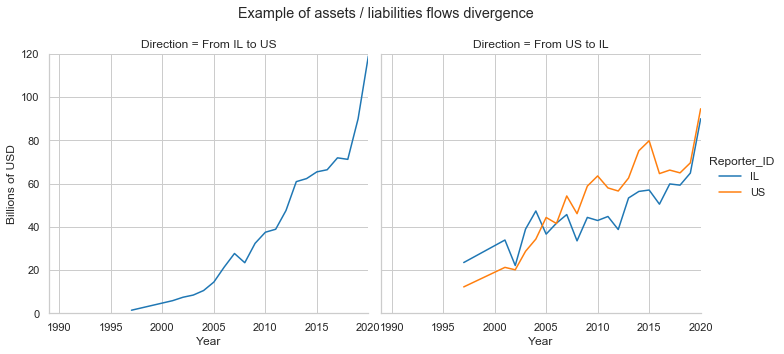

In [48]:
### IMF CPIS FLOWS: EXAMPLES

df_to_plot = ser_cpis_full.loc[All, All, list_to_plot, list_to_plot].reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Direction'] = ((df_to_plot['Flow'] == 'Asset') & (df_to_plot['Reporter_ID'] == 'IL')) | \
                          ((df_to_plot['Flow'] == 'Liability') & (df_to_plot['Reporter_ID'] == 'US'))
df_to_plot.loc[~df_to_plot['Direction'], 'Direction'] = 'From US to IL'
df_to_plot.loc[df_to_plot['Direction'] == True, 'Direction'] = 'From IL to US'
df_to_plot['Value'] = df_to_plot['Value'] / 1000
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
fig_example = sns.relplot(data = df_to_plot, x = 'Year', y = 'Value', col = 'Direction', hue = 'Reporter_ID', kind = 'line')
fig_example.set(ylim = (0, 120), xlim = (date_start.year, date_end.year), ylabel = 'Billions of USD')
fig_example.fig.subplots_adjust(top = 0.85)
fig_example.fig.suptitle('Example of assets / liabilities flows divergence')
plt.show()

Asset Reporters: 65
Asset Partners: 85
Liability Reporters: 23
Liability Partners: 85
Asset pairs number: 5429
Liability pairs number: 1742
Pairs intersection: 1738


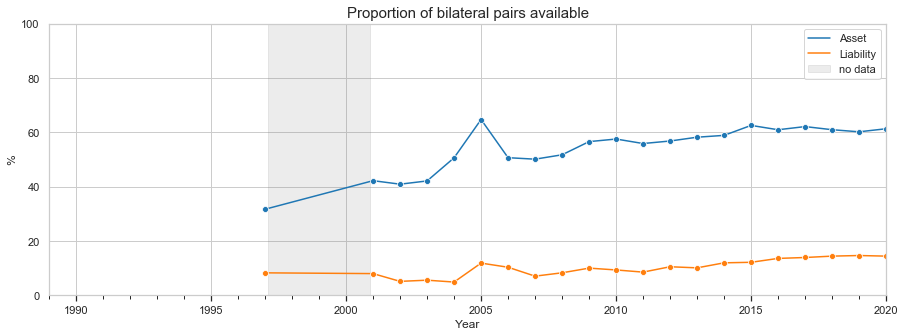

Aggregates of bilateral pairs available observations proportion (since 2001), %:
            min  median    max
Flow                         
Asset      0.0    85.0  100.0
Liability  5.0    35.0  100.0


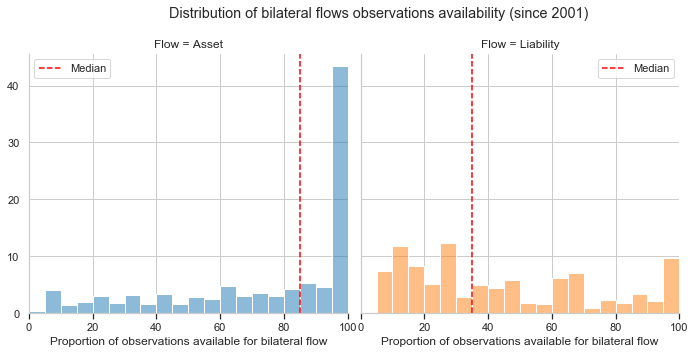

Observation dates number: 89888
Proportion of observations with both values available: 0.11
Proportion of observations with both values absent: 0.04
Proportion of observations with no asset report: 0.1
Proportion of observations with no liability report: 0.83


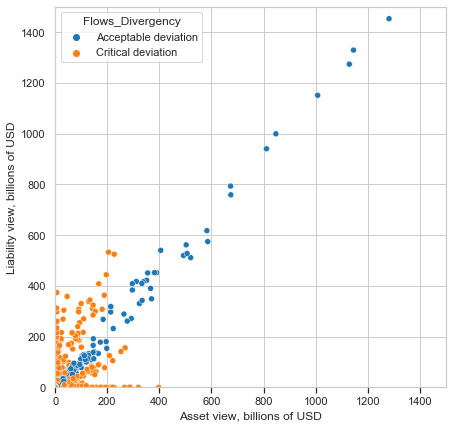

Proportion of observations with bigger Asset view:  0.07
Proportion of observations with bigger Liability view:  0.03


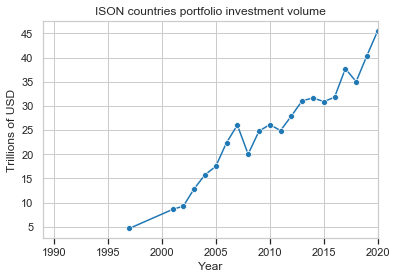

2020 minimums:
 Out_ID  In_ID
LB      IS       0.66335
Name: Portfolio_Investment, dtype: float64
2020 maximums:
 Out_ID  In_ID
JP      US       2.072497e+12
Name: Portfolio_Investment, dtype: float64
2020 medians:
 139.0


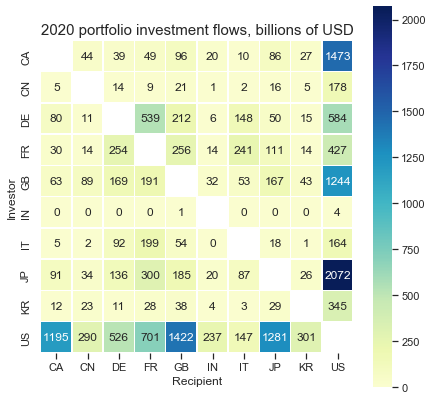

In [49]:
### IMF CPIS FLOWS: STATS

### Bilateral permutations of ISON countries
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
set_ison_pairs = set(itertools.permutations(set_ison_countries, 2))
### CPIS Data loading:
ser_cpis_asset = pd.read_hdf(path_or_buf = str_path_imf_dataset, key = str_asset_imf_dataset)
ser_cpis_liability = pd.read_hdf(path_or_buf = str_path_imf_dataset, key = str_liability_imf_dataset)
ser_cpis_full = pd.concat([ser_cpis_asset, ser_cpis_liability], keys = ['Asset', 'Liability'], names = ['Flow'])
ser_cpis_data = ser_cpis_full.loc[:, pd.date_range(date_start, date_end, freq = 'BY'), : , :]
### Countries number:
print('Asset Reporters:', len((ser_cpis_data.loc['Asset'].index.get_level_values('Reporter_ID').unique())))
print('Asset Partners:', len((ser_cpis_data.loc['Asset'].index.get_level_values('Partner_ID').unique())))
print('Liability Reporters:', len((ser_cpis_data.loc['Liability'].index.get_level_values('Reporter_ID').unique())))
print('Liability Partners:', len((ser_cpis_data.loc['Liability'].index.get_level_values('Partner_ID').unique())))
### Pairs comparision:
set_ass_pairs = set(iter_pair for iter_pair in ser_cpis_data.loc['Asset'].reset_index('Date', drop = True).index.drop_duplicates() if iter_pair[0] != iter_pair[1])
set_lia_pairs = set(iter_pair for iter_pair in ser_cpis_data.loc['Liability'].reset_index('Date', drop = True).index.drop_duplicates() if iter_pair[0] != iter_pair[1])
print('Asset pairs number:', len(set_ass_pairs))
#print('Absent asset pairs:', sorted(list(set_ison_pairs - set_ass_pairs)))
print('Liability pairs number:', len(set_lia_pairs))
#print('Absent liability pairs:', sorted(list(set_ison_pairs - set_lia_pairs)))
print('Pairs intersection:', len(set_ass_pairs.intersection(set_lia_pairs)))
### Data availability:
sns.set_style('whitegrid')
plt.rcParams.update({"xtick.bottom" : True})
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
df_to_plot = (ser_cpis_data.groupby(['Flow', 'Date']).count() / (int_ison_number * (int_ison_number - 1)) * 100).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot.rename(columns = {'Value': '%'}, inplace = True)
ax_flows = sns.lineplot(data = df_to_plot, x = 'Year', y = '%', hue = 'Flow', marker = 'o')
ax_flows.set(ylim = (0, 100), xlim = (date_start.year, date_end.year))
plt.axvspan(1997.1, 2000.9, color = 'gray', alpha = 0.15, label = 'no data')
ax_flows.xaxis.set_major_locator(mticker.IndexLocator(5, -7))
ax_flows.xaxis.set_minor_locator(mticker.IndexLocator(1, -9))
ax_flows.set_title('Proportion of bilateral pairs available', fontsize = 15)
ax_flows.legend()
plt.show()
print('Aggregates of bilateral pairs available observations proportion (since 2001), %:\n', 
      (ser_cpis_data.drop(pd.to_datetime('1997-12-31'), level = 'Date')\
       .groupby(['Flow', 'Reporter_ID', 'Partner_ID']).count() / (date_end.year - 2000) * 100).groupby('Flow').agg([min, np.median, max]).round())
df_to_plot = (ser_cpis_data.drop(pd.to_datetime('1997-12-31'), level = 'Date')\
              .groupby(['Flow', 'Reporter_ID', 'Partner_ID']).count() / (date_end.year - 2000) * 100).droplevel(['Reporter_ID', 'Partner_ID']).reset_index()
list_col_order = ['Asset', 'Liability']
fig_pairs_available = sns.displot(data = df_to_plot, col_order = list_col_order, col = 'Flow', hue = 'Flow', x = 'Value', 
                                  kde = False, bins = 20, stat = 'percent', common_norm = False)
fig_pairs_available.fig.subplots_adjust(top = 0.85)
fig_pairs_available.fig.suptitle('Distribution of bilateral flows observations availability (since 2001)')
fig_pairs_available.set(xlim = (0, 100), xlabel = 'Proportion of observations available for bilateral flow', ylabel = '')
for ax_iter, flow_iter in zip(fig_pairs_available.axes.flat, list_col_order):
    ax_iter.axvline(x = df_to_plot.loc[df_to_plot['Flow'] == flow_iter, 'Value'].median(), color = 'r', linestyle = '--', label = 'Median')
    ax_iter.legend()
fig_pairs_available._legend.remove()
plt.show()
### Empty observations:
ser_cpis_liability_inv = ser_cpis_liability + 0.0
ser_cpis_liability_inv = ser_cpis_liability_inv.reorder_levels([0, 2, 1]).sort_index()
ser_cpis_liability_inv.index.set_names([ser_cpis_liability_inv.index.names[0], ser_cpis_liability_inv.index.names[2], ser_cpis_liability_inv.index.names[1]],
                                         inplace = True)
ser_cpis_asset.name = 'Asset_View'
ser_cpis_liability_inv.name = 'Liability_View'
df_cpis_flows = pd.concat([ser_cpis_asset, ser_cpis_liability_inv], axis  = 1)
df_cpis_flows.index.set_names(['Out_ID', 'In_ID'], level = ['Reporter_ID', 'Partner_ID'], inplace = True)
df_cpis_flows = df_cpis_flows[df_cpis_flows.index.get_level_values('Out_ID') != df_cpis_flows.index.get_level_values('In_ID')]
df_cpis_flows = df_cpis_flows.loc[(pd.date_range(date_start, date_end, freq = 'BY'), All , All), :]
#df_cpis_flows.loc[(str_date_to_compare, 'CN', 'US'), :]
print('Observation dates number:', len(df_cpis_flows.index))
print('Proportion of observations with both values available:', round(len(df_cpis_flows.dropna().index) / len(df_cpis_flows.index), 2))
print('Proportion of observations with both values absent:', round(df_cpis_flows.isna().all(axis = 1).sum() / len(df_cpis_flows.index), 2))
print('Proportion of observations with no asset report:', round(df_cpis_flows['Asset_View'].isna().sum() / len(df_cpis_flows.index), 2))
print('Proportion of observations with no liability report:', round(df_cpis_flows['Liability_View'].isna().sum() / len(df_cpis_flows.index), 2))
### Asset to Liability correspondence:
df_cpis_diver = df_cpis_flows.copy()
flo_div_coeff = 3 / 2
df_cpis_diver['Flows_Ratio'] = df_cpis_diver['Asset_View'] / df_cpis_diver['Liability_View']
df_cpis_diver['Flows_Divergency'] = 'Acceptable deviation'
df_cpis_diver.loc[(df_cpis_diver['Flows_Ratio'] > flo_div_coeff) | (df_cpis_diver['Flows_Ratio'] < (1 / flo_div_coeff)), 'Flows_Divergency'] = 'Critical deviation'
df_cpis_diver[['Asset_View', 'Liability_View']] = df_cpis_diver[['Asset_View', 'Liability_View']] / 1000
plt.figure(figsize = (7, 7))
ax_divergence = sns.scatterplot(data = df_cpis_diver, x = 'Asset_View', y  = 'Liability_View', hue = 'Flows_Divergency', 
                                hue_order = ['Acceptable deviation', 'Critical deviation'])
ax_divergence.set(xlim = (0, 1500), ylim = (0, 1500), xlabel = 'Asset view, billions of USD', ylabel = 'Liability view, billions of USD')
plt.show()
print('Proportion of observations with bigger Asset view: ', 
      round(len(df_cpis_flows[df_cpis_flows['Asset_View'] > df_cpis_flows['Liability_View']]) / len(df_cpis_flows), 2))
print('Proportion of observations with bigger Liability view: ', 
      round(len(df_cpis_flows[df_cpis_flows['Asset_View'] < df_cpis_flows['Liability_View']]) / len(df_cpis_flows), 2))
### Common portfolio investment flow:
ser_cpis_port = df_cpis_flows['Asset_View']
ser_cpis_port.name = 'Portfolio_Investment'
df_to_plot = ser_cpis_port.groupby(['Date']).sum().reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Portfolio_Investment'] = df_to_plot['Portfolio_Investment'] / 1000000
ax_world_trade = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Portfolio_Investment', marker = 'o')
ax_world_trade.set(xlim = (date_start.year, date_end.year), ylabel = 'Trillions of USD', title = 'ISON countries portfolio investment volume')
plt.show()
### 2020 stats:
str_date_to_compare = '2020-12-31'
ser_2020_data = ser_cpis_port.loc[str_date_to_compare, All, All].reset_index('Date', drop = True)
ser_2020_data = ser_2020_data[ser_2020_data > 10 ** (-7)]
print('2020 minimums:\n', ser_2020_data[ser_2020_data == ser_2020_data.min()] * 1000000)
print('2020 maximums:\n', ser_2020_data[ser_2020_data == ser_2020_data.max()] * 1000000)
print('2020 medians:\n', ser_2020_data.median())
ser_2020_data = ser_cpis_port.loc[str_date_to_compare, All, All].reset_index('Date', drop = True)
list_leaders = sorted(['US', 'CN', 'JP', 'DE', 'GB', 'IN', 'FR', 'IT', 'CA', 'KR'])
ser_2020_leaders = (ser_2020_data.loc[list_leaders, list_leaders] / 1000).sort_index().astype(int)
df_2020_leaders = ser_2020_leaders.unstack('In_ID').sort_index(axis = 1)
plt.figure(figsize = (7, 7))
ax_heatmap = sns.heatmap(df_2020_leaders, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = True, annot = True, fmt = '.0f', 
                         center = 1000)
ax_heatmap.set(xlabel = 'Recipient', ylabel = 'Investor')
ax_heatmap.set_title('2020 portfolio investment flows, billions of USD', fontsize = 15)
plt.show()

In [10]:
### OECD FDI: FOREIGN DIRECT INVESTMENT

In [8]:
### OECD FDI: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
str_oecd_base_url = 'https://stats.oecd.org/sdmx-json/data/'
str_oecd_structure_url = 'https://stats.oecd.org/restsdmx/sdmx.ashx/GetDataStructure/'
str_fdi_flow_dataset_add = 'FDI_FLOW_CTRY'
str_fdi_pos_dataset_add = 'FDI_POS_CTRY'

In [12]:
### OECD FDI: REQUESTS SESSION INITIALIZING

request_session = requests.Session()
### For avoiding data request errors:
request_session.headers.update({'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'})

In [13]:
### OECD FDI: FDI FLOW STRUCTURE REQUEST

obj_oecd_structure = request_session.get(str_oecd_structure_url + str_fdi_flow_dataset_add)
xml_tree_root = et.fromstring(obj_oecd_structure.content)
dict_concepts = {}
dict_dimensions = {}
dict_codelists = {}
for xml_tree_child in xml_tree_root:
    if xml_tree_child.tag.endswith('Concepts'):
        for xml_tree_grand in xml_tree_child:
            str_concept_id = xml_tree_grand.attrib['id']
            str_concept_name = xml_tree_grand[0].text
            dict_concepts[str_concept_id] = str_concept_name
    if xml_tree_child.tag.endswith('KeyFamilies'):
        for xml_tree_family in xml_tree_child:
            for xml_tree_component in xml_tree_family:
                if xml_tree_component.tag.endswith('Components'):
                    for xml_tree_measure in xml_tree_component:
                        if xml_tree_measure.tag.endswith('Dimension'):
                            str_concept_id = xml_tree_measure.attrib['conceptRef']
                            str_concept_cl_id = xml_tree_measure.attrib['codelist']
                            dict_dimensions[str_concept_id] = str_concept_cl_id
    if xml_tree_child.tag.endswith('CodeLists'):       
        for num_tree_grand, xml_tree_grand in enumerate(xml_tree_child):
            str_codelist_id = xml_tree_grand.attrib['id']
            dict_codelist = {}
            for xml_tree_codelist in xml_tree_grand:                
                if xml_tree_codelist.tag.endswith('Code'):
                    str_code_id = xml_tree_codelist.attrib['value']
                    str_code_value = xml_tree_codelist[0].text
                    dict_codelist[str_code_id] = str_code_value
            dict_codelists[str_codelist_id] = dict_codelist

In [18]:
### OECD FDI: FDI FLOW CONCEPTS DESCRIPTION:

pd.concat([pd.Series(dict_concepts), pd.Series(dict_dimensions)], axis = 1, sort = False)

,0,1
COU,Reporting country,CL_FDI_FLOW_CTRY_COU
MEASURE,Currency,CL_FDI_FLOW_CTRY_MEASURE
MEASURE_PRINCIPLE,Measurement principle,CL_FDI_FLOW_CTRY_MEASURE_PRINCIPLE
FDI_TYPE,Type of FDI,CL_FDI_FLOW_CTRY_FDI_TYPE
TYPE_ENTITY,Type of entity,CL_FDI_FLOW_CTRY_TYPE_ENTITY
ACCOUNTING_ENTRY,Accounting entry,CL_FDI_FLOW_CTRY_ACCOUNTING_ENTRY
LEVEL_COUNTERPART,Level of counterpart,CL_FDI_FLOW_CTRY_LEVEL_COUNTERPART
COUNTERPART_AREA,Partner country/territory,CL_FDI_FLOW_CTRY_COUNTERPART_AREA
TIME,Year,CL_FDI_FLOW_CTRY_TIME
OBS_VALUE,Observation Value,NaN


In [ ]:
### OECD FDI: FDI FLOW CONCEPT SOURCE CODELISTS:

dict_codelists['CL_FDI_FLOW_CTRY_TIME']

In [60]:
### OECD FDI: FDI FLOW PARAMETERS PREPARATION: Non-country parameters:

### Currency:
str_measure = 'USD'
### Direction:
str_direction = '+'.join(['DI', 'DO'])
### Investment type:
str_fdi_type = 'T_FA_F'
### Residence defining:
str_residence = 'ALL'
### Accounting way:
str_accounting = 'NET' # '+'.join(['NET', 'A', 'L']) # 
### Level counterpart(???):
str_counterpart = 'IMC'

In [61]:
### OECD FDI: FDI FLOW PARAMETERS PREPARATION: Reporters and partners control and preparation

### ISON Countries collecting:
df_ison_countries = df_country_codes.set_index('ISO SHORT', append = True).reset_index('COUNTRY', drop = True)
df_ison_countries = df_ison_countries.reindex(ser_ison_membership.index.get_level_values(1).unique().to_list())
ser_ison_countries = df_ison_countries.reset_index().set_index('ISO LONG').squeeze()
### OECD reporters vs ISON members:
ser_oecd_reporters = pd.Series(dict_codelists['CL_FDI_FLOW_CTRY_COU'])
ser_oecd_reporters = ser_oecd_reporters.to_frame().join(ser_ison_countries).drop(0, axis = 1).squeeze()
for iter_iso_long in (ser_oecd_reporters[ser_oecd_reporters.isna()].index.get_level_values(0)):
    if iter_iso_long in ser_ison_countries.index:
        print('OECD Reporter country with no ISON match:', iter_iso_long)
### ISON countries with no OECD reporter match:
set_no_reporters = set(ser_ison_countries.dropna().index) - set(ser_oecd_reporters.index)
print('ISON countries with no OECD reporter match:', set_no_reporters, '(', len(set_no_reporters), ')')        
### OECD partners vs ISON members:
ser_oecd_partners = pd.Series(dict_codelists['CL_FDI_FLOW_CTRY_COUNTERPART_AREA'])
ser_oecd_partners = ser_oecd_partners.to_frame().join(ser_ison_countries).drop(0, axis = 1).squeeze()
for iter_iso_long in (ser_oecd_partners[ser_oecd_partners.isna()].index.get_level_values(0)):
    if iter_iso_long in ser_ison_countries.index:
        print('OECD Partner country with no ISON match:', iter_iso_long)
### ISON countries with no OECD partner match:
set_no_partners = set(ser_ison_countries.dropna().index) - set(ser_oecd_partners.index)
print('ISON countries with no OECD partner match:', set_no_partners, '(', len(set_no_partners), ')') 
### Lists preparation:
str_reporters_all = '+'.join(ser_oecd_reporters.dropna().index.to_list())
str_partners_all = '+'.join(ser_oecd_partners.dropna().index.to_list())

ISON countries with no OECD reporter match: {'PAN', 'HKG', 'LKA', 'ARE', 'PAK', 'ZMB', 'MLT', 'ZAF', 'TUN', 'OMN', 'BWA', 'QAT', 'MUS', 'ECU', 'BGR', 'CHN', 'THA', 'HRV', 'RUS', 'SAU', 'CIV', 'BHR', 'MYS', 'VNM', 'CRI', 'SRB', 'JOR', 'KAZ', 'GHA', 'BGD', 'IDN', 'SGP', 'IND', 'TWN', 'UKR', 'NAM', 'PER', 'KEN', 'CYP', 'NGA', 'BRA', 'UGA', 'KWT', 'LBN', 'EGY', 'ROU', 'ARG', 'MAR', 'PHL'} ( 49 )
ISON countries with no OECD partner match: {'ROU'} ( 1 )


In [62]:
### OECD FDI: FDI FLOW REQUEST CONSTRUCTING

str_fdi_flow_request_params = '.'.join([str_reporters_all, str_measure, str_direction, str_fdi_type, str_residence, str_accounting, str_counterpart, str_partners_all])
#str_fdi_flow_request_params = '.'.join(['CAN+USA', str_measure, str_direction, str_fdi_type, str_residence, str_accounting, str_counterpart, 'CAN+USA'])
#str_fdi_flow_request = str_oecd_base_url + str_fdi_flow_dataset_add + '/' + str_fdi_flow_request_params + '/all?detail=DataOnly'
str_fdi_flow_request = str_oecd_base_url + str_fdi_flow_dataset_add + '/' + str_fdi_flow_request_params + '/all?startTime=1980&endTime=2020&detail=DataOnly'
obj_fdi_flow_dataset = request_session.get(str_fdi_flow_request).json()
#str_fdi_flow_request

In [63]:
### OECD FDI: FDI FLOW INDEX DATA COLLECTING:

### Dates:
list_idx_dates = []
for tup_date in obj_fdi_flow_dataset['structure']['dimensions']['observation'][0]['values']:
    list_idx_dates.append(pd.to_datetime(tup_date['id']) + pd.offsets.BYearEnd())
### Parameters:    
list_idx_library = []
for iter_position in obj_fdi_flow_dataset['structure']['dimensions']['series']:
    list_param_values = []
    for tup_parameter in iter_position['values']:
        list_param_values.append(tup_parameter['id'])            
    list_idx_library.append(list_param_values)
### Result:
list_idx_library.append(list_idx_dates)
### Converting to dictionary for future replacing:
list_idx_dict = []
for iter_list in list_idx_library:
    list_idx_dict.append(dict(zip(map(str, range(len(iter_list))), iter_list)))

In [64]:
### OECD FDI: FDI FLOW DATASET RESAMPLING

dict_datasets_res = {}
dict_datasets_source = obj_fdi_flow_dataset['dataSets'][0]['series']
### Parameters and date indexes integration:
for iter_dataset in dict_datasets_source:
    dict_observations = dict_datasets_source[iter_dataset]['observations']
    for iter_observation in dict_observations:
        str_iter_idx = iter_dataset + ':' + iter_observation
        flo_iter_value = dict_observations[iter_observation][0]
        dict_datasets_res[str_iter_idx] = flo_iter_value

In [80]:
### OECD FDI: FDI FLOW DATASET REINDEXATION

df_fdi_flow_data = pd.Series(dict_datasets_res)
df_fdi_flow_data.index = pd.MultiIndex.from_arrays(zip(*df_fdi_flow_data.index.str.split(':')))
int_levels_number = df_fdi_flow_data.index.nlevels
df_fdi_flow_data = df_fdi_flow_data.reset_index()
### Replacing numbers with parameter values:
for iter_level in range(int_levels_number):
    df_fdi_flow_data['level_' + str(iter_level)].replace(list_idx_dict[iter_level], inplace = True)
    ### Replacing long ISO names with short ISO names:
    if (iter_level == 0):
        df_fdi_flow_data['level_' + str(iter_level)].replace(dict(zip(ser_oecd_reporters.index, ser_oecd_reporters)), inplace = True)
    elif (iter_level == 7):
        df_fdi_flow_data['level_' + str(iter_level)].replace(dict(zip(ser_oecd_partners.index, ser_oecd_partners)), inplace = True)      
    ### Directions renaming:
    elif (iter_level == 2):
        df_fdi_flow_data['level_' + str(iter_level)].replace({'DI': 'Inward', 'DO': 'Outward'}, inplace = True)
    ### Flow types renaming:
    elif (iter_level == 5):
        df_fdi_flow_data['level_' + str(iter_level)].replace({'NET': 'Net', 'A': 'Asset', 'L': 'Liability'}, inplace = True)      

### Indexes defining:
ser_fdi_flow_data = df_fdi_flow_data.drop(['level_3', 'level_4', 'level_6'], axis = 1)\
                    .set_index(['level_2', 'level_8', 'level_0', 'level_7', 'level_1', 'level_5']).squeeze()
ser_fdi_flow_data.index.names = ['Direction', 'Date', 'Reporter_ID', 'Partner_ID', 'Currency', 'Accounting']
ser_fdi_flow_data.sort_index(inplace = True)  
ser_fdi_flow_data = ser_fdi_flow_data[ser_fdi_flow_data.index.get_level_values('Reporter_ID') != ser_fdi_flow_data.index.get_level_values('Partner_ID')]
ser_fdi_flow_data.name = 'FDI Flows'

In [81]:
### OECD FDI: FDI FLOWS SAVING

ser_fdi_flow_data.to_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_flow_oecd_dataset, mode = 'w')

In [ ]:
### OECD FDI: FDI FLOWS: TEST

ser_test = pd.read_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_flow_oecd_dataset).droplevel(['Currency', 'Accounting'])
ser_test.loc[All, All, ['IL', 'US'], ['IL', 'US']].sort_index()

In [8]:
### OECD FDI: FDI FLOWS: EXAMPLES

ser_fdi_flow = pd.read_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_flow_oecd_dataset).droplevel(['Currency', 'Accounting'])
list_to_plot = ['IL', 'US']
print(ser_fdi_flow.loc[All, ['2011-12-30', '2020-12-31'], list_to_plot, list_to_plot].unstack(['Direction']))

Direction                               Inward      Outward
Date       Reporter_ID Partner_ID                          
2011-12-30 IL          US          2759.124123  4176.813242
           US          IL          6202.000000  -253.000000
2020-12-31 US          IL          1279.000000  7068.000000


<Figure size 1080x360 with 0 Axes>

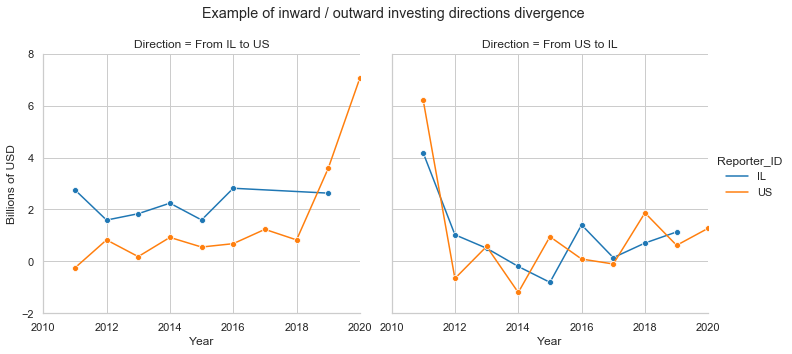

In [21]:
### OECD FDI: FDI FLOWS: EXAMPLES

df_to_plot = ser_fdi_flow.loc[All, All, list_to_plot, list_to_plot].reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Direction'] = ((df_to_plot['Direction'] == 'Inward') & (df_to_plot['Reporter_ID'] == 'IL')) | \
                          ((df_to_plot['Direction'] == 'Outward') & (df_to_plot['Reporter_ID'] == 'US'))
df_to_plot.loc[~df_to_plot['Direction'], 'Direction'] = 'From US to IL'
df_to_plot.loc[df_to_plot['Direction'] == True, 'Direction'] = 'From IL to US'
df_to_plot['Value'] = df_to_plot['FDI Flows'] / 1000
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
fig_example = sns.relplot(data = df_to_plot, x = 'Year', y = 'Value', col = 'Direction', hue = 'Reporter_ID', kind = 'line', marker = 'o')
fig_example.fig.subplots_adjust(wspace = 0.1)
fig_example.set(ylim = (-2.0, 8.0), xlim = (2010, date_end.year), ylabel = 'Billions of USD')
fig_example.fig.subplots_adjust(top = 0.85)
fig_example.fig.suptitle('Example of inward / outward investment directions divergence')
plt.show()

Outward direction Reporters: 35
Outward direction Partners: 84
Inward direction Reporters: 35
Inward direction Partners: 84
Outward direction pairs number: 2798
Inward direction pairs number: 2814
Pairs intersection: 2796


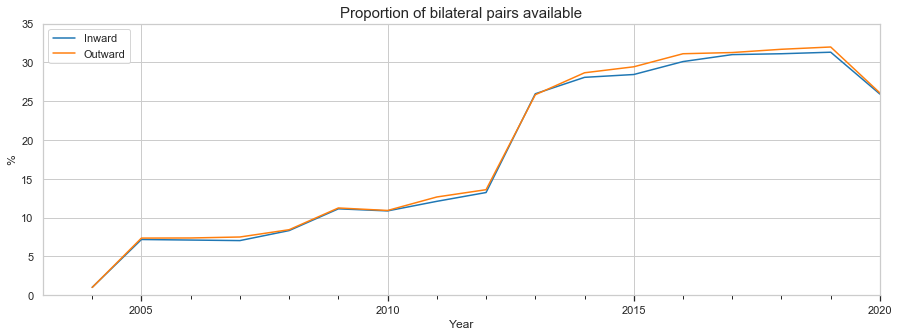

Aggregates of bilateral pairs available observations proportion (since 2004), %:
            min  median    max
Direction                    
Inward     0.0    47.0  100.0
Outward    0.0    47.0  100.0


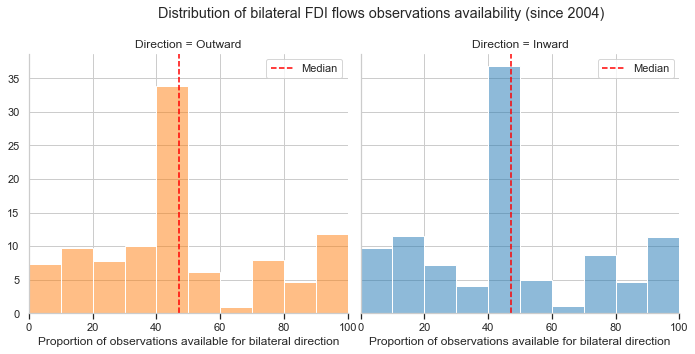

Observation dates number: 46255
Proportion of observations with both values available: 0.13
Proportion of observations with both values absent: 0.16
Proportion of observations with no outward report: 0.51
Proportion of observations with no inward report: 0.52


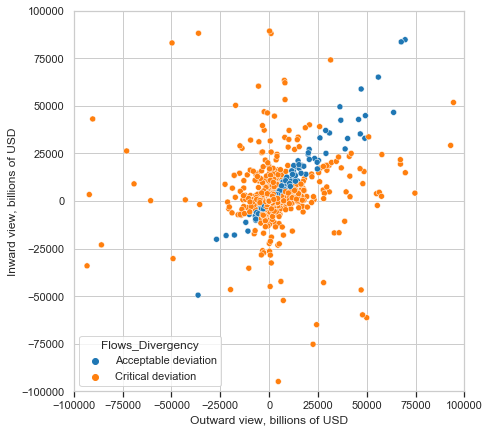

Proportion of observations with bigger Outward view:  0.06
Proportion of observations with bigger Inward view:  0.06


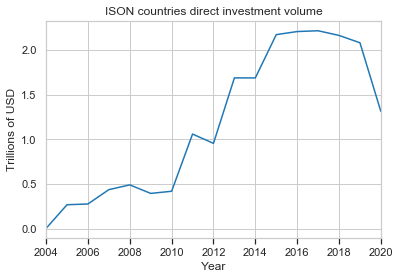

2020 minimums:
 Out_ID  In_ID
IS      IT       326.527355
Name: Direct_Investment, dtype: float64
2020 maximums:
 Out_ID  In_ID
GB      NL       1.074940e+11
Name: Direct_Investment, dtype: float64
2020 medians:
 24.322507122506998


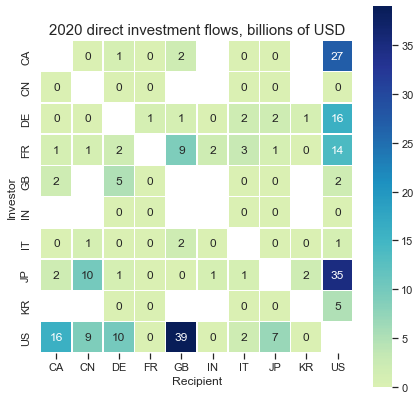

In [20]:
### OECD FDI: FDI FLOWS: STATS

### Bilateral permutations of ISON countries
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
set_ison_pairs = set(itertools.permutations(set_ison_countries, 2))
### FDI Flows data loading:
ser_fdi_flow_data = pd.read_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_flow_oecd_dataset).droplevel(['Currency', 'Accounting'])
### Countries number:
print('Outward direction Reporters:', len((ser_fdi_flow_data.loc['Outward'].index.get_level_values('Reporter_ID').unique())))
print('Outward direction Partners:', len((ser_fdi_flow_data.loc['Outward'].index.get_level_values('Partner_ID').unique())))
print('Inward direction Reporters:', len((ser_fdi_flow_data.loc['Inward'].index.get_level_values('Reporter_ID').unique())))
print('Inward direction Partners:', len((ser_fdi_flow_data.loc['Inward'].index.get_level_values('Partner_ID').unique())))
### Pairs comparision:
set_out_pairs = set(iter_pair for iter_pair in ser_fdi_flow_data.loc['Outward'].reset_index('Date', drop = True).index.drop_duplicates() if iter_pair[0] != iter_pair[1])
set_in_pairs = set(iter_pair for iter_pair in ser_fdi_flow_data.loc['Inward'].reset_index('Date', drop = True).index.drop_duplicates() if iter_pair[0] != iter_pair[1])
print('Outward direction pairs number:', len(set_out_pairs))
#print('Absent asset pairs:', sorted(list(set_ison_pairs - set_ass_pairs)))
print('Inward direction pairs number:', len(set_in_pairs))
#print('Absent liability pairs:', sorted(list(set_ison_pairs - set_lia_pairs)))
print('Pairs intersection:', len(set_out_pairs.intersection(set_in_pairs)))
### Data availability:
sns.set_style('whitegrid')
plt.rcParams.update({"xtick.bottom" : True})
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
df_to_plot = (ser_fdi_flow_data.groupby(['Direction', 'Date']).count() / (int_ison_number * (int_ison_number - 1)) * 100).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot.rename(columns = {'FDI Flows': '%'}, inplace = True)
ax_flows = sns.lineplot(data = df_to_plot, x = 'Year', y = '%', hue = 'Direction')
ax_flows.set(ylim = (0, 35), xlim = (2003, date_end.year))
ax_flows.xaxis.set_major_locator(mticker.IndexLocator(5, 1))
ax_flows.xaxis.set_minor_locator(mticker.IndexLocator(1, 0))
ax_flows.set_title('Proportion of bilateral pairs available', fontsize = 15)
ax_flows.legend()
plt.show()
print('Aggregates of bilateral pairs available observations proportion (since 2004), %:\n', 
      (ser_fdi_flow_data.groupby(['Direction', 'Reporter_ID', 'Partner_ID']).count() / (date_end.year - 2003) * 100)\
      .groupby('Direction').agg([min, np.median, max]).round())
df_to_plot = (ser_fdi_flow_data.groupby(['Direction', 'Reporter_ID', 'Partner_ID']).count() / (date_end.year - 2003) * 100).droplevel(['Reporter_ID', 'Partner_ID'])\
             .reset_index()
list_col_order = ['Outward', 'Inward']
fig_pairs_available = sns.displot(data = df_to_plot, col_order = list_col_order, col = 'Direction', hue = 'Direction', x = 'FDI Flows', 
                                  kde = False, bins = 10, stat = 'percent', common_norm = False)
fig_pairs_available.fig.subplots_adjust(top = 0.85)
fig_pairs_available.fig.suptitle('Distribution of bilateral FDI flows observations availability (since 2004)')
fig_pairs_available.set(xlim = (0, 100), xlabel = 'Proportion of observations available for bilateral direction', ylabel = '')
for ax_iter, flow_iter in zip(fig_pairs_available.axes.flat, list_col_order):
    ax_iter.axvline(x = df_to_plot.loc[df_to_plot['Direction'] == flow_iter, 'FDI Flows'].median(), color = 'r', linestyle = '--', label = 'Median')
    ax_iter.legend()
fig_pairs_available._legend.remove()    
plt.show()
### Empty observations:
ser_fdi_out = ser_fdi_flow_data.loc['Outward']
ser_fdi_in = ser_fdi_flow_data.loc['Inward']
ser_fdi_in_inv = ser_fdi_in + 0.0
ser_fdi_in_inv = ser_fdi_in_inv.reorder_levels([0, 2, 1]).sort_index()
ser_fdi_in_inv.index.set_names([ser_fdi_in_inv.index.names[0], ser_fdi_in_inv.index.names[2], ser_fdi_in_inv.index.names[1]], inplace = True)
ser_fdi_out.name = 'Outward_View'
ser_fdi_in_inv.name = 'Inward_View'
df_fdi_flows = pd.concat([ser_fdi_out, ser_fdi_in_inv], axis  = 1)
df_fdi_flows.index.set_names(['Out_ID', 'In_ID'], level = ['Reporter_ID', 'Partner_ID'], inplace = True)
df_fdi_flows = df_fdi_flows[df_fdi_flows.index.get_level_values('Out_ID') != df_fdi_flows.index.get_level_values('In_ID')]
df_fdi_flows = df_fdi_flows.loc[(pd.date_range(pd.to_datetime('2004-12-31'), date_end, freq = 'BY'), All , All), :]
df_fdi_flows.loc[('2011-12-30', 'IL', 'US'), :]
print('Observation dates number:', len(df_fdi_flows.index))
print('Proportion of observations with both values available:', round(len(df_fdi_flows.dropna().index) / len(df_fdi_flows.index), 2))
print('Proportion of observations with both values absent:', round(df_fdi_flows.isna().all(axis = 1).sum() / len(df_fdi_flows.index), 2))
print('Proportion of observations with no outward report:', round(df_fdi_flows['Outward_View'].isna().sum() / len(df_fdi_flows.index), 2))
print('Proportion of observations with no inward report:', round(df_fdi_flows['Inward_View'].isna().sum() / len(df_fdi_flows.index), 2))
### Outward to Inward correspondence:
df_fdi_diver = df_fdi_flows.copy()
flo_div_coeff = 3 / 2
df_fdi_diver['Flows_Ratio'] = df_fdi_flows['Outward_View'] / df_fdi_flows['Inward_View']
df_fdi_diver['Flows_Divergency'] = 'Acceptable deviation'
df_fdi_diver.loc[(df_fdi_diver['Flows_Ratio'] > flo_div_coeff) | (df_fdi_diver['Flows_Ratio'] < (1 / flo_div_coeff)), 'Flows_Divergency'] = 'Critical deviation'
df_fdi_diver[['Asset_View', 'Liability_View']] = df_fdi_diver[['Outward_View', 'Inward_View']] / 1000
plt.figure(figsize = (7, 7))
ax_divergence = sns.scatterplot(data = df_fdi_diver, x = 'Outward_View', y  = 'Inward_View', hue = 'Flows_Divergency', 
                                hue_order = ['Acceptable deviation', 'Critical deviation'])
ax_divergence.set(xlim = (-100000, 100000), ylim = (-100000, 100000), xlabel = 'Outward view, billions of USD', ylabel = 'Inward view, billions of USD')
plt.show()
print('Proportion of observations with bigger Outward view: ', 
      round(len(df_fdi_flows[df_fdi_flows['Outward_View'] > df_fdi_flows['Inward_View']]) / len(df_fdi_flows), 2))
print('Proportion of observations with bigger Inward view: ', 
      round(len(df_fdi_flows[df_fdi_flows['Outward_View'] < df_fdi_flows['Inward_View']]) / len(df_fdi_flows), 2))
### Signs comparision:
df_fdi_flows['Outward_Sign'] = 0
df_fdi_flows.loc[df_fdi_flows['Outward_View'] >= 0, 'Outward_Sign'] = 1
df_fdi_flows.loc[df_fdi_flows['Outward_View'] < 0, 'Outward_Sign'] = -1
df_fdi_flows['Inward_Sign'] = 0
df_fdi_flows.loc[df_fdi_flows['Inward_View'] >= 0, 'Inward_Sign'] = 1
df_fdi_flows.loc[df_fdi_flows['Inward_View'] < 0, 'Inward_Sign'] = -1
df_fdi_flows.groupby(['Outward_Sign', 'Inward_Sign']).apply(lambda df_group: len(df_group.index)) / len(df_fdi_flows)
### Common FDI flow:
ser_fdi_flow = df_fdi_flows[['Outward_View', 'Inward_View']].max(axis = 1)
ser_fdi_flow[ser_fdi_flow < 0.0] = 0.0
ser_fdi_flow.name = 'Direct_Investment'
df_to_plot = ser_fdi_flow.groupby(['Date']).sum().reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Direct_Investment'] = df_to_plot['Direct_Investment'] / 1000000
ax_world_trade = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Direct_Investment')
ax_world_trade.set(xlim = (2004, date_end.year), ylabel = 'Trillions of USD', title = 'ISON countries direct investment volume')
plt.show()
### 2020 stats:
str_date_to_compare = '2020-12-31'
ser_2020_data = ser_fdi_flow.loc[str_date_to_compare, All, All].reset_index('Date', drop = True)
ser_2020_data = ser_2020_data[ser_2020_data > 10 ** (-7)]
print('2020 minimums:\n', ser_2020_data[ser_2020_data == ser_2020_data.min()] * 1000000)
print('2020 maximums:\n', ser_2020_data[ser_2020_data == ser_2020_data.max()] * 1000000)
print('2020 medians:\n', ser_2020_data.median())
ser_2020_data = ser_fdi_flow.loc[str_date_to_compare, All, All].reset_index('Date', drop = True)
list_leaders = sorted(['US', 'CN', 'JP', 'DE', 'GB', 'IN', 'FR', 'IT', 'CA', 'KR'])
ser_2020_leaders = (ser_2020_data.loc[list_leaders, list_leaders] / 1000).sort_index().astype(int)
df_2020_leaders = ser_2020_leaders.unstack('In_ID').sort_index(axis = 1)
plt.figure(figsize = (7, 7))
ax_heatmap = sns.heatmap(df_2020_leaders, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = True, annot = True, fmt = '.0f', 
                         center = 15)
ax_heatmap.set(xlabel = 'Recipient', ylabel = 'Investor')
ax_heatmap.set_title('2020 direct investment flows, billions of USD', fontsize = 15)
plt.show()

In [14]:
### OECD FDI: FDI POSITION STRUCTURE REQUEST

obj_oecd_structure = request_session.get(str_oecd_structure_url + str_fdi_pos_dataset_add)
xml_tree_root = et.fromstring(obj_oecd_structure.content)
dict_concepts = {}
dict_dimensions = {}
dict_codelists = {}
for xml_tree_child in xml_tree_root:
    if xml_tree_child.tag.endswith('Concepts'):
        for xml_tree_grand in xml_tree_child:
            str_concept_id = xml_tree_grand.attrib['id']
            str_concept_name = xml_tree_grand[0].text
            dict_concepts[str_concept_id] = str_concept_name
    if xml_tree_child.tag.endswith('KeyFamilies'):
        for xml_tree_family in xml_tree_child:
            for xml_tree_component in xml_tree_family:
                if xml_tree_component.tag.endswith('Components'):
                    for xml_tree_measure in xml_tree_component:
                        if xml_tree_measure.tag.endswith('Dimension'):
                            str_concept_id = xml_tree_measure.attrib['conceptRef']
                            str_concept_cl_id = xml_tree_measure.attrib['codelist']
                            dict_dimensions[str_concept_id] = str_concept_cl_id
    if xml_tree_child.tag.endswith('CodeLists'):       
        for num_tree_grand, xml_tree_grand in enumerate(xml_tree_child):
            str_codelist_id = xml_tree_grand.attrib['id']
            dict_codelist = {}
            for xml_tree_codelist in xml_tree_grand:                
                if xml_tree_codelist.tag.endswith('Code'):
                    str_code_id = xml_tree_codelist.attrib['value']
                    str_code_value = xml_tree_codelist[0].text
                    dict_codelist[str_code_id] = str_code_value
            dict_codelists[str_codelist_id] = dict_codelist

In [15]:
### TEMP

pd.concat([pd.Series(dict_concepts), pd.Series(dict_dimensions)], axis = 1, sort = False).dropna()

,0,1
COU,Reporting country,CL_FDI_POS_CTRY_COU
MEASURE,Currency,CL_FDI_POS_CTRY_MEASURE
MEASURE_PRINCIPLE,Measurement principle,CL_FDI_POS_CTRY_MEASURE_PRINCIPLE
FDI_TYPE,Type of FDI,CL_FDI_POS_CTRY_FDI_TYPE
TYPE_ENTITY,Type of entity,CL_FDI_POS_CTRY_TYPE_ENTITY
ACCOUNTING_ENTRY,Accounting entry,CL_FDI_POS_CTRY_ACCOUNTING_ENTRY
LEVEL_COUNTERPART,Level of counterpart,CL_FDI_POS_CTRY_LEVEL_COUNTERPART
COUNTERPART_AREA,Partner country/territory,CL_FDI_POS_CTRY_COUNTERPART_AREA
TIME,Year,CL_FDI_POS_CTRY_TIME


In [21]:
### OECD FDI: FDI POSITION CONCEPT SOURCE CODELISTS:

dict_codelists['CL_FDI_POS_CTRY_LEVEL_COUNTERPART']

{'IMC': 'Immediate counterpart (Immediate investor or immediate host)',
 'ULT': 'Ultimate counterpart (Ultimate investor or ultimate host)'}

In [22]:
### OECD FDI: FDI POSITION PARAMETERS PREPARATION: Non-country parameters:

### Currency:
str_measure = 'USD'
### Direction:
str_direction = '+'.join(['DI', 'DO'])
### Investment type:
str_fdi_type = 'LE_FA_F'
### Residence defining:
str_residence = 'ALL'
### Accounting way:
str_accounting = 'NET' # '+'.join(['NET', 'A', 'L']) # 
### Level counterpart(???):
str_counterpart = 'IMC'

In [26]:
### OECD FDI: FDI POSITION PARAMETERS PREPARATION: Reporters and partners control and preparation

### ISON Countries collecting:
df_ison_countries = df_country_codes.set_index('ISO SHORT', append = True).reset_index('COUNTRY', drop = True)
df_ison_countries = df_ison_countries.reindex(ser_ison_membership.index.get_level_values(1).unique().to_list())
ser_ison_countries = df_ison_countries.reset_index().set_index('ISO LONG').squeeze()
### OECD reporters vs ISON members:
ser_oecd_reporters = pd.Series(dict_codelists['CL_FDI_POS_CTRY_COU'])
ser_oecd_reporters = ser_oecd_reporters.to_frame().join(ser_ison_countries).drop(0, axis = 1).squeeze()
for iter_iso_long in (ser_oecd_reporters[ser_oecd_reporters.isna()].index.get_level_values(0)):
    if iter_iso_long in ser_ison_countries.index:
        print('OECD Reporter country with no ISON match:', iter_iso_long)
### ISON countries with no OECD reporter match:
set_no_reporters = set(ser_ison_countries.dropna().index) - set(ser_oecd_reporters.index)
print('ISON countries with no OECD reporter match:', set_no_reporters, '(', len(set_no_reporters), ')')           
### OECD partners vs ISON members:
ser_oecd_partners = pd.Series(dict_codelists['CL_FDI_POS_CTRY_COUNTERPART_AREA'])
ser_oecd_partners = ser_oecd_partners.to_frame().join(ser_ison_countries).drop(0, axis = 1).squeeze()
for iter_iso_long in (ser_oecd_partners[ser_oecd_partners.isna()].index.get_level_values(0)):
    if iter_iso_long in ser_ison_countries.index:
        print('OECD Partner country with no ISON match:', iter_iso_long)
### ISON countries with no OECD partner match:
set_no_partners = set(ser_ison_countries.dropna().index) - set(ser_oecd_partners.index)
print('ISON countries with no OECD partner match:', set_no_partners, '(', len(set_no_partners), ')')
### Lists preparation:
str_reporters_all = '+'.join(ser_oecd_reporters.dropna().index.to_list())
str_partners_all = '+'.join(ser_oecd_partners.dropna().index.to_list())

ISON countries with no OECD reporter match: {'ARG', 'KAZ', 'SGP', 'VNM', 'CYP', 'ARE', 'KEN', 'NGA', 'PAK', 'CHN', 'BRA', 'LKA', 'ZAF', 'BGD', 'IDN', 'QAT', 'TUN', 'BGR', 'EGY', 'ZMB', 'CRI', 'NAM', 'LBN', 'MUS', 'HRV', 'BWA', 'BHR', 'PER', 'UKR', 'PAN', 'RUS', 'MAR', 'GHA', 'HKG', 'TWN', 'ROU', 'SRB', 'OMN', 'MLT', 'JOR', 'IND', 'SAU', 'CIV', 'PHL', 'UGA', 'MYS', 'ECU', 'THA', 'KWT'} ( 49 )
ISON countries with no OECD partner match: {'ROU'} ( 1 )


In [27]:
### OECD FDI: FDI POSITION REQUEST CONSTRUCTING

str_fdi_pos_request_params = '.'.join([str_reporters_all, str_measure, str_direction, str_fdi_type, str_residence, str_accounting, str_counterpart, str_partners_all])
str_fdi_pos_request = str_oecd_base_url + str_fdi_pos_dataset_add + '/' + str_fdi_pos_request_params + '/all?startTime=1980&endTime=2020&detail=DataOnly'
obj_fdi_pos_dataset = request_session.get(str_fdi_pos_request).json()
#str_fdi_flow_request

In [28]:
### OECD FDI: FDI POSITION INDEX DATA COLLECTING:

### Dates:
list_idx_dates = []
for tup_date in obj_fdi_pos_dataset['structure']['dimensions']['observation'][0]['values']:
    list_idx_dates.append(pd.to_datetime(tup_date['id']) + pd.offsets.BYearEnd())
### Parameters:    
list_idx_library = []
for iter_position in obj_fdi_pos_dataset['structure']['dimensions']['series']:
    list_param_values = []
    for tup_parameter in iter_position['values']:
        list_param_values.append(tup_parameter['id'])            
    list_idx_library.append(list_param_values)
### Result:
list_idx_library.append(list_idx_dates)
### Converting to dictionary for future replacing:
list_idx_dict = []
for iter_list in list_idx_library:
    list_idx_dict.append(dict(zip(map(str, range(len(iter_list))), iter_list)))

In [32]:
### OECD FDI: FDI POSITION DATASET RESAMPLING

dict_datasets_res = {}
dict_datasets_source = obj_fdi_pos_dataset['dataSets'][0]['series']
### Parameters and date indexes integration:
for iter_dataset in dict_datasets_source:
    dict_observations = dict_datasets_source[iter_dataset]['observations']
    for iter_observation in dict_observations:
        str_iter_idx = iter_dataset + ':' + iter_observation
        flo_iter_value = dict_observations[iter_observation][0]
        dict_datasets_res[str_iter_idx] = flo_iter_value

In [33]:
### OECD FDI: FDI POSITION DATASET REINDEXATION

df_fdi_pos_data = pd.Series(dict_datasets_res)
df_fdi_pos_data.index = pd.MultiIndex.from_arrays(zip(*df_fdi_pos_data.index.str.split(':')))
int_levels_number = df_fdi_pos_data.index.nlevels
df_fdi_pos_data = df_fdi_pos_data.reset_index()
### Replacing numbers with parameter values:
for iter_level in range(int_levels_number):
    df_fdi_pos_data['level_' + str(iter_level)].replace(list_idx_dict[iter_level], inplace = True)
    ### Replacing long ISO names with short ISO names:
    if (iter_level == 0):
        df_fdi_pos_data['level_' + str(iter_level)].replace(dict(zip(ser_oecd_reporters.index, ser_oecd_reporters)), inplace = True)
    elif (iter_level == 7):
        df_fdi_pos_data['level_' + str(iter_level)].replace(dict(zip(ser_oecd_partners.index, ser_oecd_partners)), inplace = True)      
    ### Directions renaming:
    elif (iter_level == 2):
        df_fdi_pos_data['level_' + str(iter_level)].replace({'DI': 'Inward', 'DO': 'Outward'}, inplace = True)
    ### Flow types renaming:
    elif (iter_level == 5):
        df_fdi_pos_data['level_' + str(iter_level)].replace({'NET': 'Net', 'A': 'Asset', 'L': 'Liability'}, inplace = True)      

### Indexes defining:
ser_fdi_pos_data = df_fdi_pos_data.drop(['level_3', 'level_4', 'level_6'], axis = 1)\
                    .set_index(['level_2', 'level_8', 'level_0', 'level_7', 'level_1', 'level_5']).squeeze()
ser_fdi_pos_data.index.names = ['Direction', 'Date', 'Reporter_ID', 'Partner_ID', 'Currency', 'Accounting']
ser_fdi_pos_data.sort_index(inplace = True)
ser_fdi_pos_data = ser_fdi_pos_data[ser_fdi_pos_data.index.get_level_values('Reporter_ID') != ser_fdi_pos_data.index.get_level_values('Partner_ID')]
ser_fdi_pos_data.name = 'FDI Positions'

In [34]:
### OECD FDI: FDI POSITIONS SAVING

ser_fdi_pos_data.to_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_pos_oecd_dataset, mode = 'r+')

In [8]:
### OECD FDI: FDI POSITIONS: TEST

ser_test = pd.read_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_pos_oecd_dataset).droplevel(['Currency', 'Accounting'])
ser_test.loc[All, All, ['IL', 'US'], ['IL', 'US']].sort_index()

Direction  Date        Reporter_ID  Partner_ID
Inward     2011-12-30  IL           US            15509.973318
                       US           IL             9290.000000
           2012-12-31  IL           US            15509.681197
                       US           IL             7361.000000
           2013-12-31  IL           US            15827.976025
                       US           IL             7041.000000
           2014-12-31  IL           US            15299.776932
                       US           IL             6175.000000
           2015-12-31  IL           US            16853.000000
                       US           IL             6865.000000
           2016-12-30  IL           US            18680.000000
                       US           IL            12271.000000
           2017-12-29  IL           US                     NaN
                       US           IL            12061.000000
           2018-12-31  IL           US            29734.000000
        

In [9]:
### OECD FDI: FDI POSITIONS: EXAMPLES

ser_fdi_pos = pd.read_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_pos_oecd_dataset).droplevel(['Currency', 'Accounting'])
list_to_plot = ['IL', 'US']
print(ser_fdi_pos.loc[All, ['2011-12-30', '2020-12-31'], list_to_plot, list_to_plot].unstack(['Direction']))

Direction                                Inward       Outward
Date       Reporter_ID Partner_ID                            
2011-12-30 IL          US          15509.973318  13197.709998
           US          IL           9290.000000   9008.000000
2020-12-31 US          IL          15227.000000  40437.000000


<Figure size 1080x360 with 0 Axes>

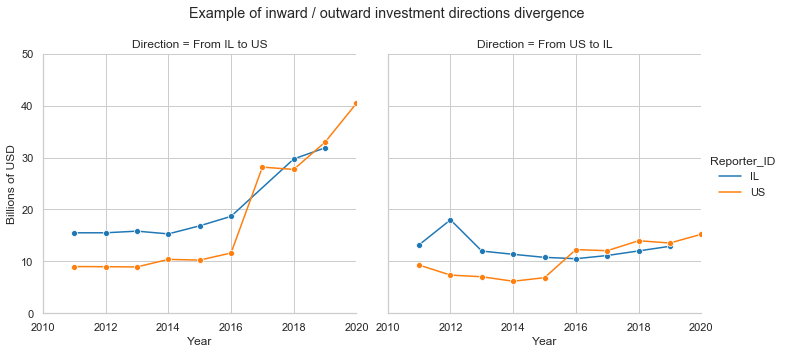

In [10]:
### OECD FDI: FDI POSITIONS: EXAMPLES

df_to_plot = ser_fdi_pos.loc[All, All, list_to_plot, list_to_plot].reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Direction'] = ((df_to_plot['Direction'] == 'Inward') & (df_to_plot['Reporter_ID'] == 'IL')) | \
                          ((df_to_plot['Direction'] == 'Outward') & (df_to_plot['Reporter_ID'] == 'US'))
df_to_plot.loc[~df_to_plot['Direction'], 'Direction'] = 'From US to IL'
df_to_plot.loc[df_to_plot['Direction'] == True, 'Direction'] = 'From IL to US'
df_to_plot['Value'] = df_to_plot['FDI Positions'] / 1000
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
fig_example = sns.relplot(data = df_to_plot, x = 'Year', y = 'Value', col = 'Direction', hue = 'Reporter_ID', kind = 'line', marker = 'o')
fig_example.fig.subplots_adjust(wspace = 0.1)
fig_example.set(ylim = (0.0, 50.0), xlim = (2010, date_end.year), ylabel = 'Billions of USD')
fig_example.fig.subplots_adjust(top = 0.85)
fig_example.fig.suptitle('Example of inward / outward investment directions divergence')
plt.show()

Outward direction Reporters: 35
Outward direction Partners: 84
Inward direction Reporters: 35
Inward direction Partners: 84
Outward direction pairs number: 2814
Inward direction pairs number: 2823
Pairs intersection: 2809


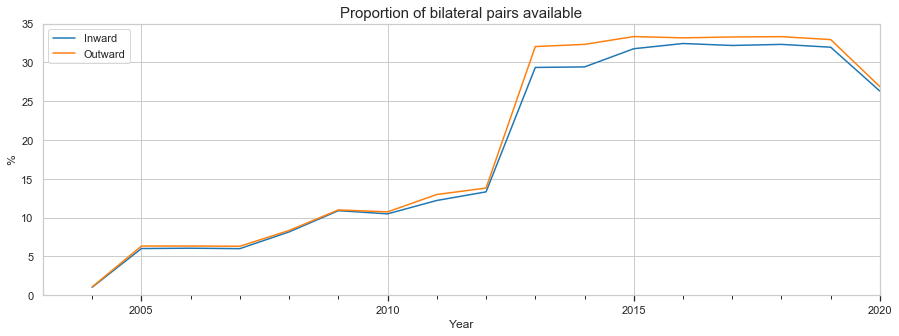

Aggregates of bilateral pairs available observations proportion (since 2004), %:
            min  median    max
Direction                    
Inward     0.0    47.0  100.0
Outward    0.0    47.0  100.0


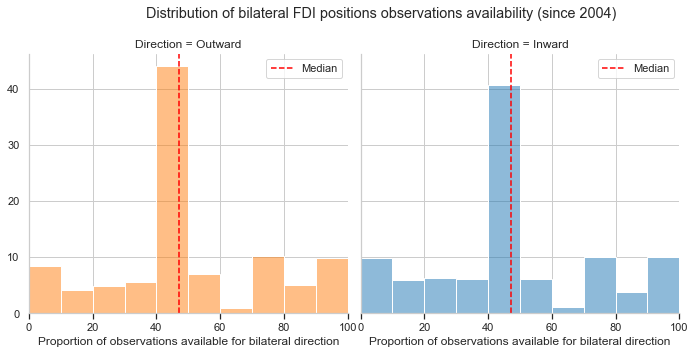

Observation dates number: 46570
Proportion of observations with both values available: 0.15
Proportion of observations with both values absent: 0.15
Proportion of observations with no outward report: 0.49
Proportion of observations with no inward report: 0.51


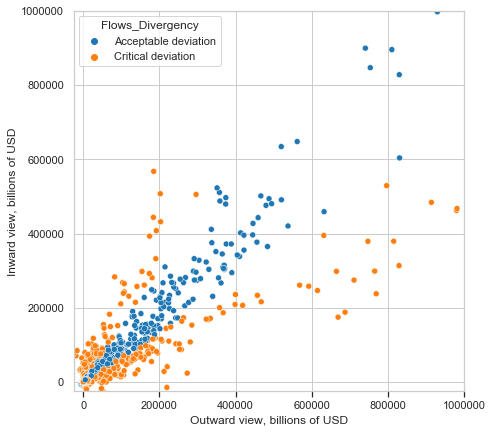

Proportion of observations with bigger Outward view:  0.07
Proportion of observations with bigger Inward view:  0.07


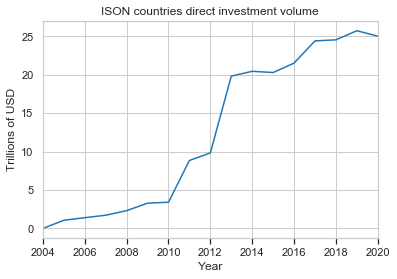

2020 minimums:
 Out_ID  In_ID
CO      GR       146.030188
Name: Direct_Investment, dtype: float64
2020 maximums:
 Out_ID  In_ID
US      NL       1.198616e+06
Name: Direct_Investment, dtype: float64
2020 medians:
 254.67692929372


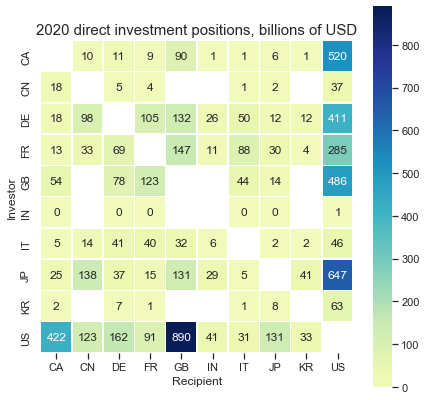

In [32]:
### OECD FDI: FDI POSITIONS: STATS

### Bilateral permutations of ISON countries
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
set_ison_pairs = set(itertools.permutations(set_ison_countries, 2))
### FDI Positions data loading:
ser_fdi_pos_data = pd.read_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_pos_oecd_dataset).droplevel(['Currency', 'Accounting'])
### Countries number:
print('Outward direction Reporters:', len((ser_fdi_pos_data.loc['Outward'].index.get_level_values('Reporter_ID').unique())))
print('Outward direction Partners:', len((ser_fdi_pos_data.loc['Outward'].index.get_level_values('Partner_ID').unique())))
print('Inward direction Reporters:', len((ser_fdi_pos_data.loc['Inward'].index.get_level_values('Reporter_ID').unique())))
print('Inward direction Partners:', len((ser_fdi_pos_data.loc['Inward'].index.get_level_values('Partner_ID').unique())))
### Pairs comparision:
set_out_pairs = set(iter_pair for iter_pair in ser_fdi_pos_data.loc['Outward'].reset_index('Date', drop = True).index.drop_duplicates() if iter_pair[0] != iter_pair[1])
set_in_pairs = set(iter_pair for iter_pair in ser_fdi_pos_data.loc['Inward'].reset_index('Date', drop = True).index.drop_duplicates() if iter_pair[0] != iter_pair[1])
print('Outward direction pairs number:', len(set_out_pairs))
#print('Absent asset pairs:', sorted(list(set_ison_pairs - set_ass_pairs)))
print('Inward direction pairs number:', len(set_in_pairs))
#print('Absent liability pairs:', sorted(list(set_ison_pairs - set_lia_pairs)))
print('Pairs intersection:', len(set_out_pairs.intersection(set_in_pairs)))
### Data availability:
sns.set_style('whitegrid')
plt.rcParams.update({"xtick.bottom" : True})
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
df_to_plot = (ser_fdi_pos_data.groupby(['Direction', 'Date']).count() / (int_ison_number * (int_ison_number - 1)) * 100).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot.rename(columns = {'FDI Positions': '%'}, inplace = True)
ax_pos = sns.lineplot(data = df_to_plot, x = 'Year', y = '%', hue = 'Direction')
ax_pos.set(ylim = (0, 35), xlim = (2003, date_end.year))
ax_pos.xaxis.set_major_locator(mticker.IndexLocator(5, 1))
ax_pos.xaxis.set_minor_locator(mticker.IndexLocator(1, 0))
ax_pos.set_title('Proportion of bilateral pairs available', fontsize = 15)
ax_pos.legend()
plt.show()
print('Aggregates of bilateral pairs available observations proportion (since 2004), %:\n', 
      (ser_fdi_pos_data.groupby(['Direction', 'Reporter_ID', 'Partner_ID']).count() / (date_end.year - 2003) * 100)\
      .groupby('Direction').agg([min, np.median, max]).round())
df_to_plot = (ser_fdi_pos_data.groupby(['Direction', 'Reporter_ID', 'Partner_ID']).count() / (date_end.year - 2003) * 100).droplevel(['Reporter_ID', 'Partner_ID'])\
             .reset_index()
list_col_order = ['Outward', 'Inward']
fig_pairs_available = sns.displot(data = df_to_plot, col_order = list_col_order, col = 'Direction', hue = 'Direction', x = 'FDI Positions', 
                                  kde = False, bins = 10, stat = 'percent', common_norm = False)
fig_pairs_available.fig.subplots_adjust(top = 0.85)
fig_pairs_available.fig.suptitle('Distribution of bilateral FDI positions observations availability (since 2004)')
fig_pairs_available.set(xlim = (0, 100), xlabel = 'Proportion of observations available for bilateral direction', ylabel = '')
for ax_iter, flow_iter in zip(fig_pairs_available.axes.flat, list_col_order):
    ax_iter.axvline(x = df_to_plot.loc[df_to_plot['Direction'] == flow_iter, 'FDI Positions'].median(), color = 'r', linestyle = '--', label = 'Median')
    ax_iter.legend()
fig_pairs_available._legend.remove()    
plt.show()
### Empty observations:
ser_fdi_out = ser_fdi_pos_data.loc['Outward']
ser_fdi_in = ser_fdi_pos_data.loc['Inward']
ser_fdi_in_inv = ser_fdi_in + 0.0
ser_fdi_in_inv = ser_fdi_in_inv.reorder_levels([0, 2, 1]).sort_index()
ser_fdi_in_inv.index.set_names([ser_fdi_in_inv.index.names[0], ser_fdi_in_inv.index.names[2], ser_fdi_in_inv.index.names[1]], inplace = True)
ser_fdi_out.name = 'Outward_View'
ser_fdi_in_inv.name = 'Inward_View'
df_fdi_pos = pd.concat([ser_fdi_out, ser_fdi_in_inv], axis  = 1)
df_fdi_pos.index.set_names(['Out_ID', 'In_ID'], level = ['Reporter_ID', 'Partner_ID'], inplace = True)
df_fdi_pos = df_fdi_pos[df_fdi_pos.index.get_level_values('Out_ID') != df_fdi_pos.index.get_level_values('In_ID')]
df_fdi_pos = df_fdi_pos.loc[(pd.date_range(pd.to_datetime('2004-12-31'), date_end, freq = 'BY'), All , All), :]
df_fdi_pos.loc[('2011-12-30', 'IL', 'US'), :]
print('Observation dates number:', len(df_fdi_pos.index))
print('Proportion of observations with both values available:', round(len(df_fdi_pos.dropna().index) / len(df_fdi_pos.index), 2))
print('Proportion of observations with both values absent:', round(df_fdi_pos.isna().all(axis = 1).sum() / len(df_fdi_pos.index), 2))
print('Proportion of observations with no outward report:', round(df_fdi_pos['Outward_View'].isna().sum() / len(df_fdi_pos.index), 2))
print('Proportion of observations with no inward report:', round(df_fdi_pos['Inward_View'].isna().sum() / len(df_fdi_pos.index), 2))
### Outward to Inward correspondence:
df_fdi_diver = df_fdi_pos.copy()
flo_div_coeff = 3 / 2
df_fdi_diver['Flows_Ratio'] = df_fdi_pos['Outward_View'] / df_fdi_pos['Inward_View']
df_fdi_diver['Flows_Divergency'] = 'Acceptable deviation'
df_fdi_diver.loc[(df_fdi_diver['Flows_Ratio'] > flo_div_coeff) | (df_fdi_diver['Flows_Ratio'] < (1 / flo_div_coeff)), 'Flows_Divergency'] = 'Critical deviation'
df_fdi_diver[['Asset_View', 'Liability_View']] = df_fdi_diver[['Outward_View', 'Inward_View']] / 1000
plt.figure(figsize = (7, 7))
ax_divergence = sns.scatterplot(data = df_fdi_diver, x = 'Outward_View', y  = 'Inward_View', hue = 'Flows_Divergency', 
                                hue_order = ['Acceptable deviation', 'Critical deviation'])
ax_divergence.set(xlim = (-25000, 1000000), ylim = (-25000, 1000000), xlabel = 'Outward view, billions of USD', ylabel = 'Inward view, billions of USD')
plt.show()
print('Proportion of observations with bigger Outward view: ', 
      round(len(df_fdi_pos[df_fdi_pos['Outward_View'] > df_fdi_pos['Inward_View']]) / len(df_fdi_pos), 2))
print('Proportion of observations with bigger Inward view: ', 
      round(len(df_fdi_pos[df_fdi_pos['Outward_View'] < df_fdi_pos['Inward_View']]) / len(df_fdi_pos), 2))
### Signs comparision:
df_fdi_pos['Outward_Sign'] = 0
df_fdi_pos.loc[df_fdi_pos['Outward_View'] >= 0, 'Outward_Sign'] = 1
df_fdi_pos.loc[df_fdi_pos['Outward_View'] < 0, 'Outward_Sign'] = -1
df_fdi_pos['Inward_Sign'] = 0
df_fdi_pos.loc[df_fdi_pos['Inward_View'] >= 0, 'Inward_Sign'] = 1
df_fdi_pos.loc[df_fdi_pos['Inward_View'] < 0, 'Inward_Sign'] = -1
df_fdi_pos.groupby(['Outward_Sign', 'Inward_Sign']).apply(lambda df_group: len(df_group.index)) / len(df_fdi_pos)
### Common FDI flow:
ser_fdi_pos = df_fdi_pos[['Outward_View', 'Inward_View']].max(axis = 1)
ser_fdi_pos[ser_fdi_pos < 0.0] = 0.0
ser_fdi_pos.name = 'Direct_Investment'
df_to_plot = ser_fdi_pos.groupby(['Date']).sum().reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Direct_Investment'] = df_to_plot['Direct_Investment'] / 1000000
ax_world_trade = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Direct_Investment')
ax_world_trade.set(xlim = (2004, date_end.year), ylabel = 'Trillions of USD', title = 'ISON countries direct investment volume')
plt.show()
### 2020 stats:
str_date_to_compare = '2020-12-31'
ser_2020_data = ser_fdi_pos.loc[str_date_to_compare, All, All].reset_index('Date', drop = True)
ser_2020_data = ser_2020_data[ser_2020_data > 10 ** (-7)]
print('2020 minimums:\n', ser_2020_data[ser_2020_data == ser_2020_data.min()] * 1000000)
print('2020 maximums:\n', ser_2020_data[ser_2020_data == ser_2020_data.max()])
print('2020 medians:\n', ser_2020_data.median())
ser_2020_data = ser_fdi_pos.loc[str_date_to_compare, All, All].reset_index('Date', drop = True)
list_leaders = sorted(['US', 'CN', 'JP', 'DE', 'GB', 'IN', 'FR', 'IT', 'CA', 'KR'])
ser_2020_leaders = (ser_2020_data.loc[list_leaders, list_leaders] / 1000).sort_index().astype(int)
df_2020_leaders = ser_2020_leaders.unstack('In_ID').sort_index(axis = 1)
plt.figure(figsize = (7, 7))
ax_heatmap = sns.heatmap(df_2020_leaders, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = True, annot = True, fmt = '.0f', 
                         center = 400)
ax_heatmap.set(xlabel = 'Recipient', ylabel = 'Investor')
ax_heatmap.set_title('2020 direct investment positions, billions of USD', fontsize = 15)
plt.show()

In [14]:
### BIS: BILATERAL BANK LENDING

In [15]:
### BIS: GET LBS DATAFLOW

### Session start:
request_session = requests.Session()
str_bis_base_url = 'https://stats.bis.org/api/v1/'
str_bis_dataflow_add = 'dataflow/BIS/all/latest?references=none&detail=allstubs'
### SDMX structure of dataflows list loading:
obj_bis_dataflow_list = request_session.get(str_bis_base_url + str_bis_dataflow_add)
xml_tree_root = et.fromstring(obj_bis_dataflow_list.content)
### Searching for LBS dataflow:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('Dataflows'):
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    str_dataflow_description = xml_tree_child_level_2[0].text
                    if ((str_dataflow_description.find('BIS') > -1) & (str_dataflow_description.find('location') > -1) & (str_dataflow_description.find('bank') > -1)):
                        str_dataflow_id = xml_tree_child_level_2.attrib['id']
                        print(str_dataflow_description, ':', str_dataflow_id)  

BIS locational banking : WEBSTATS_LBS_D_PUB_DATAFLOW


In [16]:
### BIS: GET LBS DATA STRUCTURE

str_bis_data_structure_add = 'structure/BIS/' + str_dataflow_id + '/latest?references=none&detail=full'
### SDMX structure of dataflow loading:
obj_bis_data_stucture = request_session.get(str_bis_base_url + str_bis_data_structure_add)
xml_tree_root = et.fromstring(obj_bis_data_stucture.content)
### Searching for LBS datastructure:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('Dataflows'):
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    if xml_tree_child_level_2.tag.endswith('Dataflow'):
                        for xml_tree_child_level_3 in xml_tree_child_level_2:
                            if xml_tree_child_level_3.tag.endswith('Structure'):
                                for xml_tree_child_level_4 in xml_tree_child_level_3:
                                    str_data_structure_id = xml_tree_child_level_4.attrib['id']
                                    print('Datastructure:', str_data_structure_id)

Datastructure: BIS_LBS_DISS


In [17]:
### BIS: GET LBS REQUEST STRUCTURE

str_bis_request_structure_add = 'datastructure/BIS/' + str_data_structure_id + '/latest?references=none&detail=full'
### SDMX request structure list loading:
obj_bis_request_stucture = request_session.get(str_bis_base_url + str_bis_request_structure_add)
xml_tree_root = et.fromstring(obj_bis_request_stucture.content)
### Dummy containers creating:
dict_concepts = {}
dict_codelists = {}
### LBS request positions collecting:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('DataStructures'):            
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    if xml_tree_child_level_2.tag.endswith('DataStructure'):  
                        for xml_tree_child_level_3 in xml_tree_child_level_2:
                            if xml_tree_child_level_3.tag.endswith('DataStructureComponents'): 
                                for xml_tree_child_level_4 in xml_tree_child_level_3:
                                    if xml_tree_child_level_4.tag.endswith('DimensionList'):           
                                        for xml_tree_child_level_5 in xml_tree_child_level_4:
                                            if xml_tree_child_level_5.tag.endswith('Dimension'):
                                                int_position = int(xml_tree_child_level_5.attrib['position'])
                                                for xml_tree_child_level_6 in xml_tree_child_level_5:
                                                    if xml_tree_child_level_6.tag.endswith('ConceptIdentity'):
                                                        for xml_tree_child_level_7 in xml_tree_child_level_6:
                                                            if xml_tree_child_level_7.tag.endswith('Ref'):
                                                                dict_concepts[int_position] = xml_tree_child_level_7.attrib['id']
                                                    elif xml_tree_child_level_6.tag.endswith('LocalRepresentation'):
                                                        for xml_tree_child_level_7 in xml_tree_child_level_6:
                                                            if xml_tree_child_level_7.tag.endswith('Enumeration'):
                                                                for xml_tree_child_level_8 in xml_tree_child_level_7:
                                                                    if xml_tree_child_level_8.tag.endswith('Ref'):
                                                                        dict_codelists[int_position] = xml_tree_child_level_8.attrib['id']
### LBS request structure consolidating:                                                                        
df_lbs_concept = pd.concat([pd.Series(dict_concepts), pd.Series(dict_codelists)], axis = 1, keys = ['Concept', 'Codelist'])
print('Request structure:\n', df_lbs_concept)

Request structure:
             Concept            Codelist
1              FREQ             CL_FREQ
2         L_MEASURE       CL_STOCK_FLOW
3        L_POSITION       CL_L_POSITION
4           L_INSTR          CL_L_INSTR
5           L_DENOM    CL_CURRENCY_3POS
6       L_CURR_TYPE      CL_L_CURR_TYPE
7      L_PARENT_CTY  CL_BIS_IF_REF_AREA
8   L_REP_BANK_TYPE      CL_L_BANK_TYPE
9         L_REP_CTY  CL_BIS_IF_REF_AREA
10      L_CP_SECTOR         CL_L_SECTOR
11     L_CP_COUNTRY  CL_BIS_IF_REF_AREA
12       L_POS_TYPE       CL_L_POS_TYPE
13      TIME_PERIOD                 NaN


In [18]:
### BIS: GET LBS CONCEPTS OPTIONS

### Dummy container creating:
df_lbs_concept['Options'] = np.NaN
### Searching for LBS concepts options:
for iter_pos, iter_row in df_lbs_concept.iterrows():
    if isinstance(iter_row['Codelist'], str):
        dict_options = {}
        str_lbs_codelist_add = 'codelist/BIS/' + iter_row['Codelist'] + '/latest?references=none&detail=full'
        ### SDMX codelist options list loading:
        obj_bis_codelist_options = request_session.get(str_bis_base_url + str_lbs_codelist_add)
        xml_tree_root = et.fromstring(obj_bis_codelist_options.content)
        ### LBS reqCodelists options collecting:
        for xml_tree_child_level_0 in xml_tree_root:
            if xml_tree_child_level_0.tag.endswith('Structures'):
                for xml_tree_child_level_1 in xml_tree_child_level_0:
                    if xml_tree_child_level_1.tag.endswith('Codelists'):
                        for xml_tree_child_level_2 in xml_tree_child_level_1:
                            if xml_tree_child_level_2.tag.endswith('Codelist'):
                                for xml_tree_child_level_3 in xml_tree_child_level_2:
                                    if xml_tree_child_level_3.tag.endswith('Code'):
                                        str_option_id = xml_tree_child_level_3.attrib['id']
                                        for xml_tree_child_level_4 in xml_tree_child_level_3:
                                            if xml_tree_child_level_4.tag.endswith('Name'):
                                                dict_options[str_option_id] = xml_tree_child_level_4.text
        iter_row['Options'] = dict_options
        df_lbs_concept.loc[iter_pos] = iter_row
        
print('Request structure & options:\n', df_lbs_concept)

Request structure & options:
             Concept            Codelist  \
1              FREQ             CL_FREQ   
2         L_MEASURE       CL_STOCK_FLOW   
3        L_POSITION       CL_L_POSITION   
4           L_INSTR          CL_L_INSTR   
5           L_DENOM    CL_CURRENCY_3POS   
6       L_CURR_TYPE      CL_L_CURR_TYPE   
7      L_PARENT_CTY  CL_BIS_IF_REF_AREA   
8   L_REP_BANK_TYPE      CL_L_BANK_TYPE   
9         L_REP_CTY  CL_BIS_IF_REF_AREA   
10      L_CP_SECTOR         CL_L_SECTOR   
11     L_CP_COUNTRY  CL_BIS_IF_REF_AREA   
12       L_POS_TYPE       CL_L_POS_TYPE   
13      TIME_PERIOD                 NaN   

                                              Options  
1   {'A': 'Annual', 'B': 'Daily - business week (n...  
2   {'F': 'FX and break adjusted change (BIS calcu...  
3   {'B': 'Local claims', 'C': 'Total claims', 'D'...  
4   {'A': 'All instruments', 'D': 'Debt securities...  
5   {'AED': 'UAE Dirham', 'AFA': 'Afghani (old)', ...  
6   {'A': 'All currencies (=D+F

In [20]:
### BIS: SELECTING LBS CONCEPTS OPTIONS

int_pos = 12
# 1 to 12
print(df_lbs_concept.loc[int_pos, 'Concept'], '/', df_lbs_concept.loc[int_pos, 'Codelist'], ':\n', end = '')
print(pd.Series(df_lbs_concept.loc[int_pos, 'Options']))
#  1 - FREQUENCY - 'Q': 'Quaterly'
#  2 - MEASURE - 'S': Amounts outstanding / Stocks'
#  3 - BALANCE SHEET POSITION - 'C': 'Total claims' / 'L': 'Total liabilities'
#  4 - TYPE OF INSTRUMENTS - 'A': 'All instruments'
#  5 - CURRENCY DENOMINATION - 'TO1': 'All currencies'
#  6 - CURRENCY TYPE - 'A': 'All currencies'
#  7 - PARENT COUNTRY - '5J': 'All countries'
#  8 - TYPE OF REPORTING INSTITUTION - 'A': 'All reporting banks/institutions (domestic, foreign, consortium and unclassified)'
#  9 - REPORTING COUNTRY - we need to construct request for all ISON countries as reporters
# 10 - COUNTERPARTY SECTOR - 'A': 'All sectors'
# 11 - COUNTERPARTY COUNTRY - we need to construct request for all ISON countries as partners
# 12 - POSITION TYPE - 'N': 'Cross-border'
# 13 - TIME PERIOD

L_POS_TYPE / CL_L_POS_TYPE :
A                            All
N                   Cross-border
R                          Local
U                    Unallocated
I    Cross-border & Local in FCY
dtype: object


In [ ]:
### BIS: ANNUAL REQUESTS

### Container initializing:
list_lbs_data = []
### Looping over needed date range year-by year:
for iter_year in range(date_start.year, date_end.year + 1): # [1989, 1990]: # 
    str_bis_data_year_add = 'data/WEBSTATS_LBS_D_PUB_DATAFLOW/Q.S..A.TO1.A.5J.A..A..N/all?startPeriod=' \
                            + str(iter_year) + '-Q1&endPeriod=' + str(iter_year) + '-Q4&detail=dataonly'    
    ### SDMX structure of dataflow loading:
    obj_bis_data_annual = request_session.get(str_bis_base_url + str_bis_data_year_add)
    xml_tree_root = et.fromstring(obj_bis_data_annual.content)
    ### LBS data collecting:
    for xml_tree_child_level_0 in xml_tree_root:
        if xml_tree_child_level_0.tag.endswith('DataSet'):
            for xml_tree_child_level_1 in xml_tree_child_level_0:
                if xml_tree_child_level_1.tag.endswith('Series'):
                    ### Series attributes getting:
                    str_position = xml_tree_child_level_1.attrib['L_POSITION']
                    str_rep_country = xml_tree_child_level_1.attrib['L_REP_CTY']
                    str_cp_country = xml_tree_child_level_1.attrib['L_CP_COUNTRY']
                    ### Series values getting:
                    dict_values = {}
                    for xml_tree_child_level_2 in xml_tree_child_level_1:
                        if xml_tree_child_level_2.tag.endswith('Obs'):
                            dict_values[xml_tree_child_level_2.attrib['TIME_PERIOD']] = xml_tree_child_level_2.attrib['OBS_VALUE']
                    ### Transforming data to series:
                    list_lbs_data.append(pd.concat([pd.Series(dict_values)], keys = [(str_position, str_rep_country, str_cp_country)], 
                                                    names = ['Position', 'Reporter_ID', 'Partner_ID']))
    print(str(iter_year), ': data loaded')
#    break

In [38]:
### BIS: DATA MANIPULATING

### Converting container to series:
ser_lbs_quarter = pd.concat(list_lbs_data)
### Period index preparing:
ser_lbs_quarter.index.names = ser_lbs_quarter.index.names[: -1] + ['Quarter']
ser_lbs_quarter.index = ser_lbs_quarter.index.set_levels(pd.to_datetime(ser_lbs_quarter.index.levels[-1]), level = 'Quarter')
### ISON filtering:
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
ser_lbs_quarter = ser_lbs_quarter.loc[All, list(set_ison_countries), list(set_ison_countries), All]
#### Data type casting:
ser_lbs_quarter = ser_lbs_quarter.astype(float).sort_index()
### Resampling to annual frequency:
ser_lbs_year = ser_lbs_quarter.groupby(['Position', 'Reporter_ID', 'Partner_ID'])\
                              .apply(lambda iter_group: iter_group.droplevel(['Position', 'Reporter_ID', 'Partner_ID']).resample('BY').sum())
### Zero years to NaN (there are no full zero years in original quaterly data) after resampling:
ser_lbs_year = ser_lbs_year.replace({0.0: np.NaN})
### Index ordering:
ser_lbs_year.index.names = ser_lbs_year.index.names[: -1] + ['Date']
ser_lbs_year = ser_lbs_year.reorder_levels([0, 3, 1, 2])
ser_lbs_year.name = 'Value'

In [43]:
### BIS: DATA SAVING

ser_lbs_year.loc['C'].to_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_claim_dataset, mode = 'w')
ser_lbs_year.loc['L'].to_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_liability_dataset, mode = 'r+')

In [52]:
### BIS POSITIONS: TEST

ser_test = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_claim_dataset)
ser_test.loc[All, ['IL', 'US'], ['IL', 'US']].sort_index()
ser_test = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_liability_dataset)
ser_test.loc[All, ['IL', 'US'], ['IL', 'US']].sort_index()

Date        Reporter_ID  Partner_ID
1989-12-29  US           IL             3620.0
1990-12-31  US           IL             3477.0
1991-12-31  US           IL             4009.0
1992-12-31  US           IL             4607.0
1993-12-31  US           IL             6470.0
1994-12-30  US           IL             7453.0
1995-12-29  US           IL             7320.0
1996-12-31  US           IL             6761.0
1997-12-31  US           IL             8980.0
1998-12-31  US           IL            11355.0
1999-12-31  US           IL            15253.0
2000-12-29  US           IL            16686.0
2001-12-31  US           IL            16939.0
2002-12-31  US           IL            17007.0
2003-12-31  US           IL            18547.0
2004-12-31  US           IL            21386.0
2005-12-30  US           IL            19033.0
2006-12-29  US           IL            19612.0
2007-12-31  US           IL            28043.0
2008-12-31  US           IL            27394.0
2009-12-31  US          

In [10]:
### BIS POSITIONS: EXAMPLES

ser_lbs_claim = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_claim_dataset)
ser_lbs_liability = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_liability_dataset)
ser_lbs_full = pd.concat([ser_lbs_claim, ser_lbs_liability], keys = ['Claim', 'Liability'], names = ['Position'])
list_to_plot = ['GB', 'US']
str_date_to_compare = '2020-12-31'
print(ser_lbs_full.loc[All, ['1989-12-29', '2020-12-31'], list_to_plot, list_to_plot].unstack(['Position']))

Position                               Claim  Liability
Date       Reporter_ID Partner_ID                      
1989-12-29 GB          US           512982.0   627910.0
           US          GB           267349.0   424923.0
2020-12-31 GB          US          5494755.0  4830765.0
           US          GB          3286480.0  3338392.0


<Figure size 1080x360 with 0 Axes>

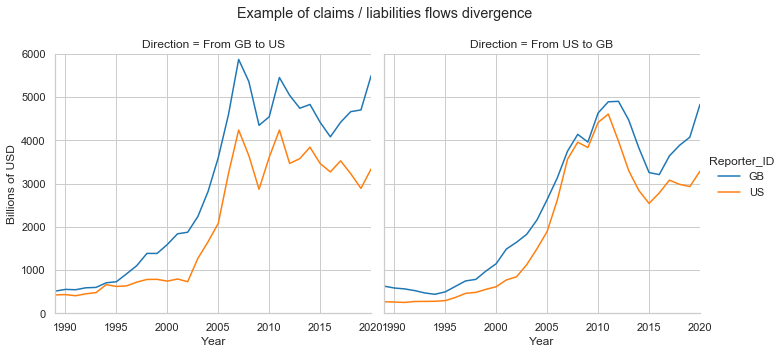

In [11]:
### BIS POSITIONS: EXAMPLES

df_to_plot = ser_lbs_full.loc[All, All, list_to_plot, list_to_plot].reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Direction'] = ((df_to_plot['Position'] == 'Claim') & (df_to_plot['Reporter_ID'] == 'GB')) | \
                          ((df_to_plot['Position'] == 'Liability') & (df_to_plot['Reporter_ID'] == 'US'))
df_to_plot.loc[~df_to_plot['Direction'], 'Direction'] = 'From US to GB'
df_to_plot.loc[df_to_plot['Direction'] == True, 'Direction'] = 'From GB to US'
df_to_plot['Value'] = df_to_plot['Value'] / 1000
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
fig_example = sns.relplot(data = df_to_plot, x = 'Year', y = 'Value', col = 'Direction', hue = 'Reporter_ID', kind = 'line')
fig_example.set(ylim = (0, 6000), xlim = (date_start.year, date_end.year), ylabel = 'Billions of USD')
fig_example.fig.subplots_adjust(top = 0.85)
fig_example.fig.suptitle('Example of claims / liabilities flows divergence')
plt.show()

Claim Reporters: 26
Claim Partners: 85
Liability Reporters: 26
Liability Partners: 85
Claim pairs number: 2015
Liability pairs number: 2065
Pairs intersection: 1981


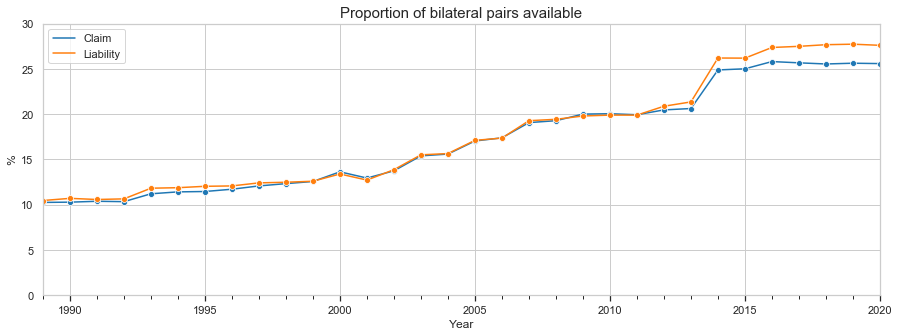

Aggregates of bilateral pairs available observations proportion, %:
            min  median    max
Position                     
Claim      0.0    59.0  100.0
Liability  0.0    59.0  100.0


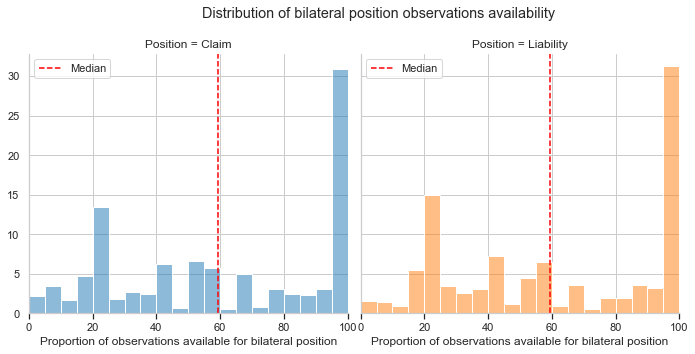

Observation dates number: 88281
Proportion of observations with both values available: 0.12
Proportion of observations with both values absent: 0.22
Proportion of observations with no claim report: 0.56
Proportion of observations with no liability report: 0.54


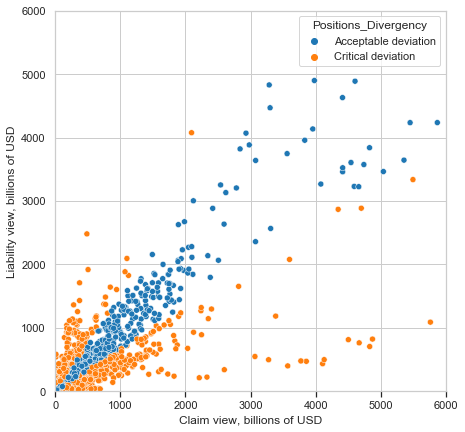

Proportion of observations with bigger Claim view:  0.07
Proportion of observations with bigger Liability view:  0.04


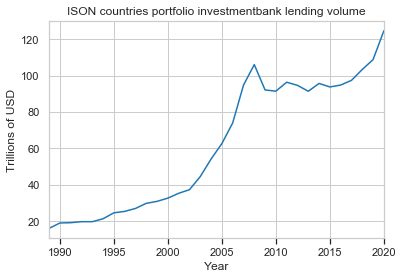

In [9]:
### BIS POSITIONS: STATS

### Bilateral permutations of ISON countries
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
set_ison_pairs = set(itertools.permutations(set_ison_countries, 2))
### BIS Lending Data loading:
ser_lbs_claim = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_claim_dataset)
ser_lbs_liability = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_liability_dataset)
ser_lbs_data = pd.concat([ser_lbs_claim, ser_lbs_liability], keys = ['Claim', 'Liability'], names = ['Position'])
### Countries number:
print('Claim Reporters:', len((ser_lbs_data.loc['Claim'].index.get_level_values('Reporter_ID').unique())))
print('Claim Partners:', len((ser_lbs_data.loc['Claim'].index.get_level_values('Partner_ID').unique())))
print('Liability Reporters:', len((ser_lbs_data.loc['Liability'].index.get_level_values('Reporter_ID').unique())))
print('Liability Partners:', len((ser_lbs_data.loc['Liability'].index.get_level_values('Partner_ID').unique())))
### Pairs comparision:
set_ass_pairs = set(iter_pair for iter_pair in ser_lbs_data.loc['Claim'].reset_index('Date', drop = True).index.drop_duplicates() if iter_pair[0] != iter_pair[1])
set_lia_pairs = set(iter_pair for iter_pair in ser_lbs_data.loc['Liability'].reset_index('Date', drop = True).index.drop_duplicates() if iter_pair[0] != iter_pair[1])
print('Claim pairs number:', len(set_ass_pairs))
#print('Absent asset pairs:', sorted(list(set_ison_pairs - set_ass_pairs)))
print('Liability pairs number:', len(set_lia_pairs))
#print('Absent liability pairs:', sorted(list(set_ison_pairs - set_lia_pairs)))
print('Pairs intersection:', len(set_ass_pairs.intersection(set_lia_pairs)))
### Data availability:
sns.set_style('whitegrid')
plt.rcParams.update({"xtick.bottom" : True})
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
df_to_plot = (ser_lbs_data.groupby(['Position', 'Date']).count() / (int_ison_number * (int_ison_number - 1)) * 100).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot.rename(columns = {'Value': '%'}, inplace = True)
ax_flows = sns.lineplot(data = df_to_plot, x = 'Year', y = '%', hue = 'Position', marker = 'o')
ax_flows.set(ylim = (0, 30), xlim = (date_start.year, date_end.year))
ax_flows.xaxis.set_major_locator(mticker.IndexLocator(5, 1))
ax_flows.xaxis.set_minor_locator(mticker.IndexLocator(1, 0))
ax_flows.set_title('Proportion of bilateral pairs available', fontsize = 15)
ax_flows.legend()
plt.show()
print('Aggregates of bilateral pairs available observations proportion, %:\n', 
      (ser_lbs_data.groupby(['Position', 'Reporter_ID', 'Partner_ID']).count() / (date_end.year - 1988) * 100).groupby('Position').agg([min, np.median, max]).round())
df_to_plot = (ser_lbs_data.groupby(['Position', 'Reporter_ID', 'Partner_ID']).count() / (date_end.year - 1988) * 100).droplevel(['Reporter_ID', 'Partner_ID']).reset_index()
list_col_order = ['Claim', 'Liability']
fig_pairs_available = sns.displot(data = df_to_plot, col_order = list_col_order, col = 'Position', hue = 'Position', x = 'Value', 
                                  kde = False, bins = 20, stat = 'percent', common_norm = False)
fig_pairs_available.fig.subplots_adjust(top = 0.85)
fig_pairs_available.fig.suptitle('Distribution of bilateral position observations availability')
fig_pairs_available.set(xlim = (0, 100), xlabel = 'Proportion of observations available for bilateral position', ylabel = '')
for ax_iter, flow_iter in zip(fig_pairs_available.axes.flat, list_col_order):
    ax_iter.axvline(x = df_to_plot.loc[df_to_plot['Position'] == flow_iter, 'Value'].median(), color = 'r', linestyle = '--', label = 'Median')
    ax_iter.legend()
fig_pairs_available._legend.remove()
plt.show()
### Empty observations:
ser_lbs_liability_inv = ser_lbs_liability + 0.0
ser_lbs_liability_inv = ser_lbs_liability_inv.reorder_levels([0, 2, 1]).sort_index()
ser_lbs_liability_inv.index.set_names([ser_lbs_liability_inv.index.names[0], ser_lbs_liability_inv.index.names[2], ser_lbs_liability_inv.index.names[1]],
                                       inplace = True)
ser_lbs_claim.name = 'Claim_View'
ser_lbs_liability_inv.name = 'Liability_View'
df_lbs_positions = pd.concat([ser_lbs_claim, ser_lbs_liability_inv], axis  = 1)
df_lbs_positions.index.set_names(['Out_ID', 'In_ID'], level = ['Reporter_ID', 'Partner_ID'], inplace = True)
df_lbs_positions = df_lbs_positions[df_lbs_positions.index.get_level_values('Out_ID') != df_lbs_positions.index.get_level_values('In_ID')]
df_lbs_positions = df_lbs_positions.loc[(pd.date_range(date_start, date_end, freq = 'BY'), All , All), :]
#df_cpis_flows.loc[(str_date_to_compare, 'CN', 'US'), :]
print('Observation dates number:', len(df_lbs_positions.index))
print('Proportion of observations with both values available:', round(len(df_lbs_positions.dropna().index) / len(df_lbs_positions.index), 2))
print('Proportion of observations with both values absent:', round(df_lbs_positions.isna().all(axis = 1).sum() / len(df_lbs_positions.index), 2))
print('Proportion of observations with no claim report:', round(df_lbs_positions['Claim_View'].isna().sum() / len(df_lbs_positions.index), 2))
print('Proportion of observations with no liability report:', round(df_lbs_positions['Liability_View'].isna().sum() / len(df_lbs_positions.index), 2))
### Claim to Liability correspondence:
df_lbs_diver = df_lbs_positions.copy()
flo_div_coeff = 3 / 2
df_lbs_diver['Positions_Ratio'] = df_lbs_diver['Claim_View'] / df_lbs_diver['Liability_View']
df_lbs_diver['Positions_Divergency'] = 'Acceptable deviation'
df_lbs_diver.loc[(df_lbs_diver['Positions_Ratio'] > flo_div_coeff) | (df_lbs_diver['Positions_Ratio'] < (1 / flo_div_coeff)), 'Positions_Divergency'] = 'Critical deviation'
df_lbs_diver[['Claim_View', 'Liability_View']] = df_lbs_diver[['Claim_View', 'Liability_View']] / 1000
plt.figure(figsize = (7, 7))
ax_divergence = sns.scatterplot(data = df_lbs_diver, x = 'Claim_View', y  = 'Liability_View', hue = 'Positions_Divergency', 
                                hue_order = ['Acceptable deviation', 'Critical deviation'])
ax_divergence.set(xlim = (0, 6000), ylim = (0, 6000), xlabel = 'Claim view, billions of USD', ylabel = 'Liability view, billions of USD')
plt.show()
print('Proportion of observations with bigger Claim view: ', 
      round(len(df_lbs_positions[df_lbs_positions['Claim_View'] > df_lbs_positions['Liability_View']]) / len(df_lbs_positions), 2))
print('Proportion of observations with bigger Liability view: ', 
      round(len(df_lbs_positions[df_lbs_positions['Claim_View'] < df_lbs_positions['Liability_View']]) / len(df_lbs_positions), 2))
### Common portfolio investment flow:
ser_lbs_port = df_lbs_positions[['Claim_View', 'Liability_View']].max(axis = 1)
ser_lbs_port.name = 'Bank_Lending'
df_to_plot = ser_lbs_port.groupby(['Date']).sum().reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Bank_Lending'] = df_to_plot['Bank_Lending'] / 1000000
ax_world_trade = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Bank_Lending')
ax_world_trade.set(xlim = (date_start.year, date_end.year), ylabel = 'Trillions of USD', title = 'ISON countries portfolio investmentbank lending volume')
plt.show()

2020 minimums:
 Out_ID  In_ID
TN      PH       1000.0
Name: Bank_Lending, dtype: float64
2020 maximums:
 Out_ID  In_ID
JP      US       5.762564e+12
Name: Bank_Lending, dtype: float64
2020 medians:
 708.0


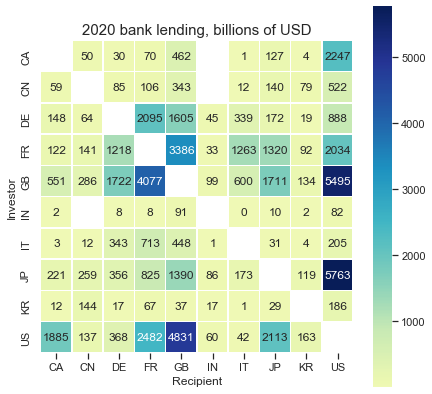

In [18]:
### TEMP

### 2020 stats:
str_date_to_compare = '2020-12-31'
ser_2020_data = ser_lbs_port.loc[str_date_to_compare, All, All].reset_index('Date', drop = True)
ser_2020_data = ser_2020_data[ser_2020_data > 10 ** (-7)]
print('2020 minimums:\n', ser_2020_data[ser_2020_data == ser_2020_data.min()] * 1000000)
print('2020 maximums:\n', ser_2020_data[ser_2020_data == ser_2020_data.max()] * 1000000)
print('2020 medians:\n', ser_2020_data.median())
ser_2020_data = ser_lbs_port.loc[str_date_to_compare, All, All].reset_index('Date', drop = True)
list_leaders = sorted(['US', 'CN', 'JP', 'DE', 'GB', 'IN', 'FR', 'IT', 'CA', 'KR'])
ser_2020_leaders = (ser_2020_data.loc[list_leaders, list_leaders] / 1000).sort_index()#.astype('Int64')
df_2020_leaders = ser_2020_leaders.unstack('In_ID').sort_index(axis = 1)
plt.figure(figsize = (7, 7))
ax_heatmap = sns.heatmap(df_2020_leaders, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = True, annot = True, fmt = '.0f', 
                         center = 2500)
ax_heatmap.set(xlabel = 'Recipient', ylabel = 'Investor')
ax_heatmap.set_title('2020 bank lending, billions of USD', fontsize = 15)
plt.show()

In [12]:
### RETURNS LOADING AND CONTROL

### Bloomberg data loading:
ser_returns = pd.read_hdf(str_path_bb_hdf, key = str_key_ret_monthly)
ser_mmr = pd.read_hdf(str_path_bb_hdf, key = str_key_mmr)

### List of countries with de-facto equal returns (to impact on hedged returns calculating)
ser_ret_similarity_test = ser_returns.unstack('Currency').groupby('Country').apply(lambda df_country: (df_country['LOC'] - df_country['USD']).abs().mean())
set_ret_usd_only = set(ser_ret_similarity_test.loc[ser_ret_similarity_test < flo_returns_similarity].index)
### List of countries with unsufficient data quantity:
ser_ret_completeness_test = ser_returns.groupby('Country').apply(lambda ser_country: ser_country.count() / len(ser_country.index))
set_not_complete = set(ser_ret_completeness_test.loc[ser_ret_completeness_test < flo_returns_completeness].index)
### Filtering uncomplete countries:
ser_returns.loc[All, All, set_not_complete] = np.NaN
### Returns options preparing:
dict_ser_ret = {}
### Returns in local currency:
dict_ser_ret['LOC'] = ser_returns.loc['LOC', All, All].droplevel(0)
### Returns in USD:
dict_ser_ret['USD'] = ser_returns.loc['USD', All, All].droplevel(0)
### Hedged returns in local currency:
dict_ser_hedged = {}
### Filling data for countries with no MMR data:
set_ison_countries = set(dict_ser_ret['LOC'].index.get_level_values(1).unique())
set_mmr_countries = set(ser_mmr.index.get_level_values(1).unique())
set_no_mmr_countries = (set_ison_countries - set_mmr_countries) | set_ret_usd_only
set_to_hedge_countries = set_mmr_countries - set_no_mmr_countries
dict_ser_hedged['No_MMR'] = dict_ser_ret['USD'].loc[All, set_no_mmr_countries]
### Money Market rates shifting forward:
ser_mmr_shifted = ser_mmr.groupby('Country').shift(1)
### Filling data for other countries:
df_ser_hedged = pd.DataFrame()
df_ser_hedged['Returns LOC'] = dict_ser_ret['LOC'].loc[All, set_to_hedge_countries]
df_ser_hedged = df_ser_hedged.join(ser_mmr_shifted, how = 'left')
df_ser_hedged.columns = ['Returns LOC', 'MMR LOC']
dict_ser_hedged['MMR_Based'] = df_ser_hedged.groupby('Country', group_keys = False)\
                               .apply(lambda df_country: (1 + df_country['Returns LOC']) * (1 + ser_mmr_shifted.loc[All, 'US'] / 12) / (1 + df_country['MMR LOC'] / 12) - 1)
#dict_ser_hedged['MMR_Based'] = df_ser_hedged.groupby('Country', group_keys = False)\
#                               .apply(lambda df_country: (1 + df_country['Returns LOC']) * (((1 + ser_mmr.loc[All, 'US']) / (1 + df_country['MMR LOC'])) ** (1 /12)) - 1)
### Aggregating hedged returns:
dict_ser_ret['HEDGED'] = pd.concat(dict_ser_hedged).droplevel(0).sort_index()

In [9]:
### WORLD BANK: WDI: GDP

In [10]:
### WORLD BANK: WDI: GDP: GENERAL DATA PREPARATION

All = slice(None)
dict_request_accept = {'Accept': 'application/vnd.sdmx.data+json;version=1.0.0-wd'}
str_wdi_base_url = 'http://api.worldbank.org/v2/sdmx/rest/'
str_wdi_dataflow_add = 'dataflow'
str_wdi_codelist_add = 'codelist/'

In [11]:
### WORLD BANK: WDI: GDP: REQUESTS SESSION INITIALIZING

request_session = requests.Session()

In [12]:
### WORLD BANK: WDI: GDP: DATAFLOW SEARCHING

### Dataflows info loading:
obj_imf_dataflows_list = request_session.get(str_wdi_base_url + str_wdi_dataflow_add)
xml_tree_root = et.fromstring(obj_imf_dataflows_list.content)
### Dataflows container initialiazing:
dict_dataflow = {}
### Dataflows data collecting:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('Dataflows'):
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    for xml_tree_child_level_3 in xml_tree_child_level_2:
                        if (xml_tree_child_level_3.tag.endswith('Structure')):
                            for xml_tree_child_level_4 in xml_tree_child_level_3:
                                if (xml_tree_child_level_4.tag.endswith('Ref')):
                                    str_dataflow_id = xml_tree_child_level_4.attrib['id']
                                    str_agency_id = xml_tree_child_level_4.attrib['agencyID']
                                    dict_dataflow[str_agency_id] = str_dataflow_id
### WDI dataflow selecting:
print(dict_dataflow)
for iter_dataflow in dict_dataflow:
    if (dict_dataflow[iter_dataflow] == 'WDI'):
        str_dataflow_id = dict_dataflow[iter_dataflow]
        str_agency_id = iter_dataflow

{'UNSD': 'SDG', 'WB': 'WDI'}


In [13]:
### WORLD BANK: WDI: GDP: CODELISTS GATHERING

### Codelists info loading:
obj_wb_codelists_list = request_session.get(str_wdi_base_url + str_wdi_codelist_add + str_agency_id.lower())
xml_tree_root = et.fromstring(obj_wb_codelists_list.content)
### Codelists containers initialiazing:
dict_description = {}
dict_codelist = {}
str_list_id = None
### Codelists data collecting:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('Codelists'):
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    if xml_tree_child_level_2.tag.endswith('Codelist'):
                        if (str_list_id is None):
                            pass
                        else:
                            dict_codelist[str_list_id] = dict_codes
                        str_list_id = xml_tree_child_level_2.attrib['id']
                        for xml_tree_child_level_3 in xml_tree_child_level_2:
                            if xml_tree_child_level_3.tag.endswith('Name'):
                                str_description = xml_tree_child_level_3.text
                                dict_description[str_list_id] = str_description
                                dict_codes = {}
                            else:
                                str_code = xml_tree_child_level_3.attrib['id']
                                for xml_tree_child_level_4 in xml_tree_child_level_3:
                                    if xml_tree_child_level_4.tag.endswith('Name'):
                                        str_value = xml_tree_child_level_4.text
                                        dict_codes[str_code] = str_value
                dict_codelist[str_list_id] = dict_codes

In [14]:
### WORLD BANK: WDI: GDP: CODELISTS CHECK

dict_description
dict_codelist
for iter_codelist in dict_description:
    print(dict_description[iter_codelist], '(', iter_codelist, '):')
    print(pd.Series(dict_codelist[iter_codelist]).head())

Frequency code list ( CL_FREQ_WDI ):
A                    Annual
2A         Two-year average
3A       Three-year average
S     Half-yearly, semester
Q                 Quarterly
dtype: object
Reference area code list ( CL_REF_AREA_WDI ):
AFG       Afghanistan
ALB           Albania
DZA           Algeria
ASM    American Samoa
AND           Andorra
dtype: object
Series code list ( CL_SERIES_WDI ):
PA_NUS_PPP_05        2005 PPP conversion factor, GDP (LCU per inter...
PA_NUS_PRVT_PP_05    2005 PPP conversion factor, private consumptio...
EG_ELC_ACCS_ZS                 Access to electricity (% of population)
EG_ELC_ACCS_RU_ZS    Access to electricity, rural (% of rural popul...
EG_ELC_ACCS_UR_ZS    Access to electricity, urban (% of urban popul...
dtype: object
Units multipliers code list ( CL_UNIT_MULT_WDI ):
0                Units
1                 Tens
2             Hundreds
3            Thousands
4    Tens of thousands
dtype: object


In [15]:
### WORLD BANK: WDI: GDP: ISON MEMBERS FILTER AND CHECK

ser_ison_long = df_country_codes.loc[df_country_codes['ISO SHORT'].isin(ser_ison_membership.index.get_level_values('Country').unique()), 'ISO LONG']
ser_wdi_all_country = pd.Series(list(dict_codelist['CL_REF_AREA_WDI'].keys()), list(dict_codelist['CL_REF_AREA_WDI'].values()))
ser_wdi_ison_country = ser_wdi_all_country.loc[ser_wdi_all_country.isin(ser_ison_long)]
print('ISON Countries with no GDP Data from WB WDI:', sorted(list(set(ser_ison_long.values) - set(ser_wdi_ison_country.values))))

ISON Countries with no GDP Data from WB WDI: ['TWN']


In [16]:
### WORLD BANK: WDI: GDP: SERIES SEARCHING

ser_dataset = pd.Series(dict_codelist['CL_SERIES_WDI']) 
print(ser_dataset[ser_dataset.str.startswith('GDP')])
str_gdp_dataset = 'NY_GDP_MKTP_CD'

NY_GDP_MKTP_KN                                         GDP (constant LCU)
NY_GDP_MKTP_CN                                          GDP (current LCU)
NY_GDP_MKTP_KD                   GDP at market prices (constant 2005 US$)
NY_GDP_MKTP_CD                         GDP at market prices (current US$)
NY_GDP_DEFL_ZS                 GDP deflator (base year varies by country)
NY_GDP_MKTP_KD_ZG                                   GDP growth (annual %)
NY_GDP_PCAP_KD                         GDP per capita (constant 2005 US$)
NY_GDP_PCAP_KN                              GDP per capita (constant LCU)
NY_GDP_PCAP_CN                               GDP per capita (current LCU)
NY_GDP_PCAP_CD                               GDP per capita (current US$)
NY_GDP_PCAP_KD_ZG                        GDP per capita growth (annual %)
NY_GDP_PCAP_PP_KD       GDP per capita, PPP (constant 2011 internation...
NY_GDP_PCAP_PP_CD           GDP per capita, PPP (current international $)
SL_GDP_PCAP_EM_KD           GDP per pe

In [144]:
### WORLD BANK: WDI: GDP: DATA EXTRACTING

### To receive data in JSON format:
request_session.headers.update(dict_request_accept)

str_data_freq = 'Q' ### Data frequency
int_step = 10 ### Countries number for each request
### Full container initializing:
list_full_gdp = []
### Looping over countries list:
for iter_count in range(int(len(ser_wdi_ison_country) / int_step) + 1):
    ### Step container initializing:
    dict_step_gdp = {}    
    ### Countries portion extraction:
    list_iter_countries = sorted(ser_wdi_ison_country.values[iter_count * int_step : (iter_count + 1) * int_step])
    print(list_iter_countries)
    ### Request performing:
    obj_wb_gdp_list = request_session.get(str_wdi_base_url + 'data/' + str_dataflow_id.lower() + '/' + \
                                          '.'.join([str_data_freq, str_gdp_dataset, '+'.join(list_iter_countries)]) + \
                                          '/?startperiod=' + str(date_start.year) + '&endPeriod=' + str(date_end.year))
    ### Data reading as JSON:
#    dict_step_json = obj_wb_gdp_list.json() ### Empty array error
    dict_step_json = json.loads(obj_wb_gdp_list.text.replace('[,', '[-1,'))
    ### Headers dropping to extract values:
    dict_data_series = dict_step_json['dataSets'][0]['series']
    ### Looping over country data dictionaries:
    for iter_series_id in dict_data_series:
        ### Internal country code:
        str_iter_country_num = iter_series_id[0]
        ### Country values extracting:
        dict_iter_values = dict_data_series[iter_series_id]['observations']
        ser_iter_values = pd.DataFrame(pd.Series(dict_iter_values).to_list())[0]
        ### Adding country data to container:
        dict_step_gdp[str_iter_country_num] = ser_iter_values
    ### Receiving country codes registry:
    ser_step_countries = pd.DataFrame(dict_step_json['structure']['dimensions']['series'][2]['values'])['id']
    dict_country_id = ser_step_countries.to_dict()
    ### Receiving date codes registry:
    ser_step_years = pd.DataFrame(pd.DataFrame(dict_step_json['structure']['dimensions']['observation'][0])['values'].to_list())['id']
    ### Converting year numbers to dates:
    ser_step_dates = pd.to_datetime(ser_step_years) + pd.offsets.BYearEnd()
    dict_date_id = ser_step_dates.to_dict()
    ### Converting country and date ids to values:
    df_step_gdp = pd.DataFrame(dict_step_gdp)
    df_step_gdp.columns = list(map(lambda x: dict_country_id[x], map(int, df_step_gdp.columns)))
    df_step_gdp.index = list(map(lambda x: dict_date_id[x], map(int, df_step_gdp.index)))
    list_full_gdp.append(df_step_gdp)
### Data aggregation:
df_full_gdp = pd.concat(list_full_gdp, axis = 1, sort = True).sort_index(axis = 1)
### Dumb replace reverting:
df_full_gdp = df_full_gdp.replace(-1, np.NaN)
### Converting ISO long codes to ISO short codes:
df_full_gdp.columns = df_country_codes.set_index('ISO LONG').squeeze().reindex(df_full_gdp.columns).values
### Data stacking:
ser_full_gdp = df_full_gdp.stack(dropna = False)
ser_full_gdp.index.names = ['Date', 'Country']
ser_full_gdp.name = 'Value'
### Data saving:
ser_full_gdp.to_hdf(path_or_buf = str_path_wb_gdp_dataset, key = str_wb_gdp_dataset, mode = 'w')

['ARG', 'AUS', 'AUT', 'BEL', 'BGD', 'BGR', 'BHR', 'BRA', 'BWA', 'CAN']
['CHL', 'CHN', 'CIV', 'COL', 'CRI', 'CYP', 'CZE', 'DNK', 'ECU', 'HRV']
['DEU', 'EGY', 'EST', 'FIN', 'FRA', 'GHA', 'GRC', 'HKG', 'HUN', 'ISL']
['IDN', 'IND', 'IRL', 'ISR', 'ITA', 'JOR', 'JPN', 'KAZ', 'KEN', 'KOR']
['KWT', 'LBN', 'LTU', 'LVA', 'MAR', 'MEX', 'MLT', 'MUS', 'MYS', 'NAM']
['NGA', 'NLD', 'NOR', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'POL']
['PRT', 'QAT', 'ROU', 'RUS', 'SAU', 'SGP', 'SRB', 'SVK', 'SVN', 'ZAF']
['ARE', 'CHE', 'ESP', 'LKA', 'SWE', 'THA', 'TUN', 'TUR', 'UGA', 'UKR']
['GBR', 'USA', 'VNM', 'ZMB']


Date        Country
1990-12-31  IS          6.468736
2000-12-29  IS          9.025660
2010-12-31  IS         13.751162
2020-12-31  IS         21.718076
Name: Value, dtype: float64

<Figure size 1080x360 with 0 Axes>

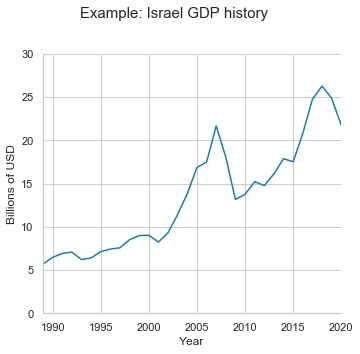

In [159]:
### WORLD BANK: WDI: GDP: EXAMPLES

ser_full_gdp = pd.read_hdf(path_or_buf = str_path_wb_gdp_dataset, key = str_wb_gdp_dataset)
ser_example = ser_full_gdp.loc[All, ['IS']] / 1000000000
display(ser_example[1::10])

df_example = ser_example.reset_index('Date')
df_example['Year'] = df_example['Date'].dt.year
df_example = df_example.set_index('Date')
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
fig_example = sns.relplot(data = df_example, x = 'Year', y = 'Value', kind = 'line')
fig_example.set(ylim = (0, 30), xlim = (date_start.year, date_end.year), ylabel = 'Billions of USD')
fig_example.fig.subplots_adjust(top = 0.85)
fig_example.fig.suptitle('Example: Israel GDP history', fontsize = 15)
plt.show()

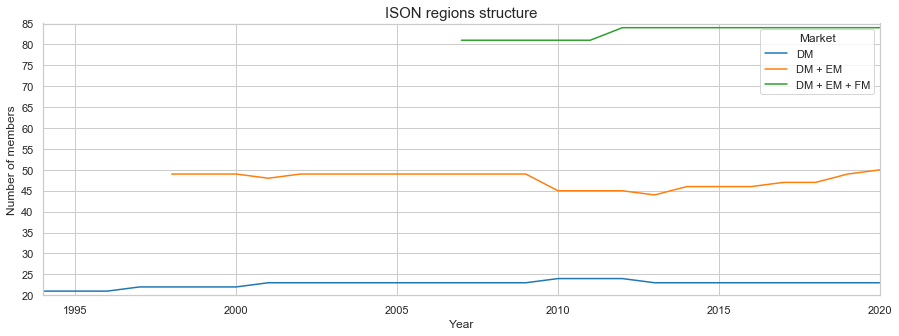

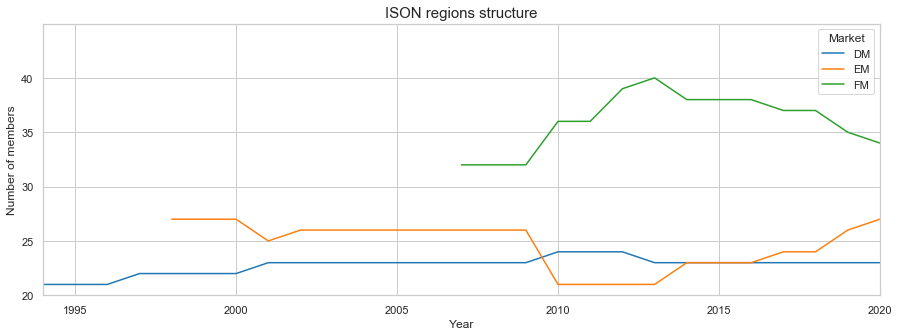

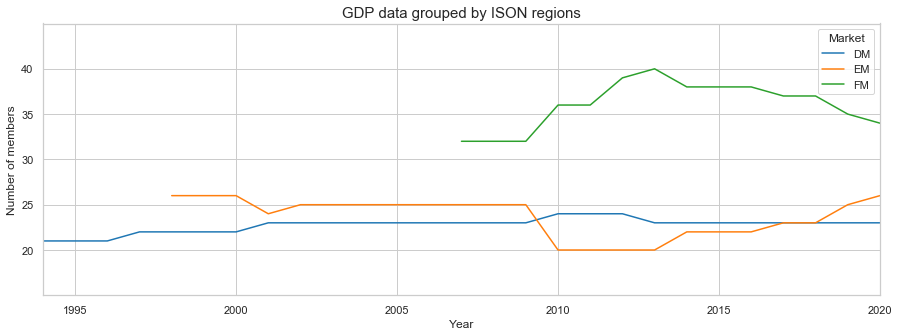

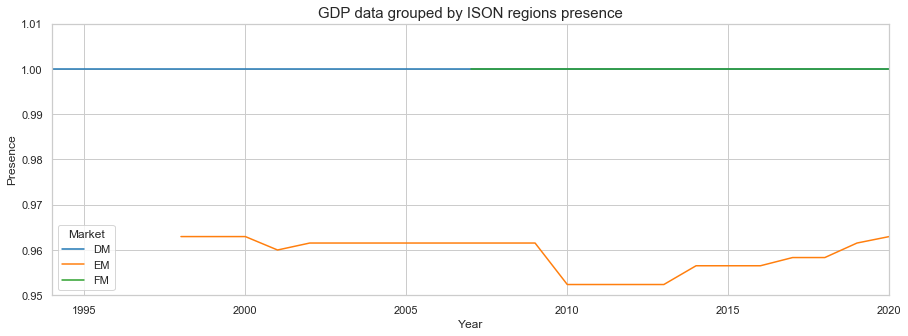

In [8]:
### WORLD BANK: WDI: GDP: DATA PRESENCE STATISTICS

### Data loading and ISONing
ser_full_gdp = pd.read_hdf(path_or_buf = str_path_wb_gdp_dataset, key = str_wb_gdp_dataset)
ser_ison_gdp = ser_full_gdp.to_frame().join(ser_ison_membership).dropna(subset = ['Market']).set_index('Market', append = True).squeeze() / 1000000000
### ISON Annual stats:
ser_ison_count = ser_ison_membership.to_frame().reset_index('Country').set_index('Market', append = True).squeeze().groupby(['Date', 'Market']).count()
ser_ison_count = ser_ison_count.reset_index('Market').groupby('Market', group_keys = False).resample('BY').last().set_index('Market', append = True).squeeze()
ser_ison_count.name = 'Number of members'
### Convert ISON registry to sums to better visualize ISON growth:
df_ison_sum = ser_ison_count.unstack('Market')
df_ison_sum['DM + EM'] = df_ison_sum['DM'] + df_ison_sum['EM']
df_ison_sum['DM + EM + FM'] = df_ison_sum['DM + EM'] + df_ison_sum['FM']
df_ison_sum = df_ison_sum[['DM', 'DM + EM', 'DM + EM + FM']]
ser_ison_sum = df_ison_sum.stack()
ser_ison_sum.index.set_names('Market', level = -1, inplace = True)
ser_ison_sum.name = 'Number of members'
### Sum view of ISON registry:
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
df_ison_show = ser_ison_sum.reset_index()
df_ison_show['Year'] = df_ison_show['Date'].dt.year
ax_ison_sum = sns.lineplot(data = df_ison_show, x = 'Year', y = 'Number of members', hue = 'Market')
ax_ison_sum.set(ylim = (20, 85), xlim = (date_ison.year, date_end.year))
ax_ison_sum.yaxis.set_major_locator(mticker.IndexLocator(5, -1))
ax_ison_sum.set_title('ISON regions structure', fontsize = 15)
### Separate view of ISON registry:
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
df_ison_show = ser_ison_count.reset_index()
df_ison_show['Year'] = df_ison_show['Date'].dt.year
ax_ison_count = sns.lineplot(data = df_ison_show, x = 'Year', y = 'Number of members', hue = 'Market')
ax_ison_count.set(ylim = (20, 45), xlim = (date_ison.year, date_end.year))
ax_ison_count.yaxis.set_major_locator(mticker.IndexLocator(5, -1))
ax_ison_count.set_title('ISON regions structure', fontsize = 15)
### WB GDP Annual stats:
ser_gdp_count = ser_ison_gdp.reset_index('Country')['Country']
ser_gdp_count = ser_ison_gdp.reset_index('Country')['Country'].groupby(['Date', 'Market']).count()
ser_gdp_count.name = 'Number of members'
ser_gdp_part = ser_gdp_count / ser_ison_count
ser_gdp_part.name = 'Presence'
### Separate view of GDP data grouped by ISON regions:
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
df_gdp_show = ser_gdp_count.reset_index()
df_gdp_show['Year'] = df_gdp_show['Date'].dt.year
ax_gdp_count = sns.lineplot(data = df_gdp_show, x = 'Year', y = 'Number of members', hue = 'Market')
ax_gdp_count.set(ylim = (15, 45), xlim = (date_ison.year, date_end.year))
ax_gdp_count.yaxis.set_major_locator(mticker.IndexLocator(5, 0))
ax_gdp_count.set_title('GDP data grouped by ISON regions', fontsize = 15)
### Separate view of GDP data grouped by ISON regions:
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
df_gdp_show = ser_gdp_part.reset_index()
df_gdp_show['Year'] = df_gdp_show['Date'].dt.year
ax_gdp_count = sns.lineplot(data = df_gdp_show, x = 'Year', y = 'Presence', hue = 'Market')
ax_gdp_count.set(ylim = (0.95, 1.01), xlim = (date_ison.year, date_end.year))
ax_gdp_count.set_title('GDP data grouped by ISON regions presence', fontsize = 15)
### Results demonstration:
plt.show()

Market  Country  Market
DM      US       DM        20953.030000
EM      CN       EM        14722.730698
FM      NG       FM          432.293776
Name: Value, dtype: float64
Market  Country  Market
DM      NZ       DM        210.700849
EM      KW       EM        105.960226
FM      NA       FM         10.619195
Name: Value, dtype: float64


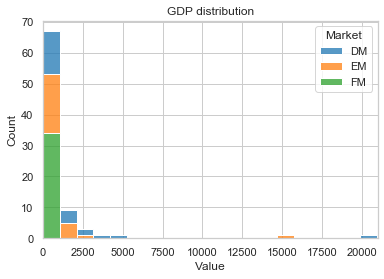

In [54]:
### WORLD BANK: WDI: GDP: NUMERIC STATISTICS

### 2020 stats:
ser_last_gdp = ser_ison_gdp.loc[ser_ison_gdp.index.levels[0].max(), All, All].reset_index('Date', drop = True)
print(ser_last_gdp.groupby('Market').apply(lambda ser_x: ser_x.nlargest(1)))
print(ser_last_gdp.groupby('Market').apply(lambda ser_x: ser_x.nsmallest(1)))
df_last_gdp = ser_last_gdp.reset_index()
ax_gdp_hist = sns.histplot(df_last_gdp, x = 'Value', hue = 'Market', hue_order = ['DM', 'EM', 'FM'], kde = False, bins = 20, multiple = 'stack')
ax_gdp_hist.set(xlim = (0, 21000), title = 'GDP distribution')

plt.show()

In [ ]:
### TEMP

df_last_gdp = ser_last_gdp.reset_index('Market')